# A Google Meridian PyMC-Marketing Comparison

Intro here

In [1]:
# Standard imports
import re
import time
import warnings

# IPython and Jupyter-specific
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Third-party imports
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import xarray as xr
from pympler import asizeof
from statsmodels.stats.stattools import durbin_watson

import nutpie

# PyMC Marketing
from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation, HillSaturationSigmoid
from pymc_marketing.mmm.multidimensional import (
    MMM,
    MultiDimensionalBudgetOptimizerWrapper,
)
from pymc_marketing.prior import Prior

# Meridian
from meridian import constants
from meridian.analysis import analyzer, formatter, optimizer, summarizer, visualizer
from meridian.data import (
    data_frame_input_data_builder,
    input_data,
    load,
    test_utils,
)
from meridian.model import model, prior_distribution, spec

# Data generation
from mmm_param_recovery.data_generator import (
    generate_mmm_dataset,
    get_preset_config,
)

# Warnings and plotting style
warnings.filterwarnings("ignore", category=UserWarning)
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

2025-08-08 21:52:44.960184: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 21:52:44.987353: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/teemu/pymc-labs/mmm-param-recovery/.pixi/envs/default/lib/python3.12/site-packages/pymc_marketing/mmm/multidimensional.py:72: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warni

In [2]:
# Set random seed for reproduceability
seed: int = sum(map(ord, "mmm_multidimensional"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## The Data

A description of the data

In [3]:
dataset_names = ["small_business", "growing_business"]

In [4]:
datasets = []
channel_columns_list = []
truth_dfs = []
for name in dataset_names:
    business_config = get_preset_config(name)
    business_result = generate_mmm_dataset(business_config)
    data_df = business_result['data'].rename(columns = {"date": "time"})
    print(f"{name.replace("_", " ").title()} dataset shape: {data_df.shape}")
    data_df["population"] = 1
    print(f"Regions: {data_df['geo'].unique()}")
    print(f"Date range: {data_df['time'].min()} to {data_df['time'].max()}")
    print("")
    print("="*20)
    print("")
    datasets.append(data_df)
    channel_columns_list.append([col for col in data_df.columns if re.match(r"x\d+", col)])
    truth_dfs.append(business_result['ground_truth']['transformed_spend'].reset_index().rename(columns={"date": "time"}))


Small Business dataset shape: (104, 11)
Regions: ['geo_a']
Date range: 2020-01-05 00:00:00 to 2021-12-26 00:00:00


Growing Business dataset shape: (262, 13)
Regions: ['geo_a' 'geo_b']
Date range: 2020-01-05 00:00:00 to 2022-07-03 00:00:00




## Data Pre-Processing

In [5]:
# Meridian

# Storage for built data objects
built_data_objects = []

for data_df, channel_columns in zip(datasets, channel_columns_list):
    # Detect control columns in the form of 'c1', ..., 'c10' if present
    potential_controls = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10']
    control_cols = [col for col in potential_controls if col in data_df.columns]

    # Start building the data input
    builder = (
        data_frame_input_data_builder.DataFrameInputDataBuilder(kpi_type='revenue')
        .with_kpi(data_df, kpi_col="y")
        .with_population(data_df)
    )

    # Add controls only if any are found
    if control_cols:
        builder = builder.with_controls(data_df, control_cols=control_cols)

    # Add media columns
    builder = builder.with_media(
        data_df,
        media_cols=channel_columns,
        media_spend_cols=channel_columns,
        media_channels=channel_columns,
    )

    # Finalize the builder and store the result
    built_data = builder.build()
    built_data_objects.append(built_data)

# PyMC-Marketing
# None required.

## Prior Specification 

**Meridian**

- Uses spend share as prior variance for $\beta$ parameters, across channels - does not allow for geo level.
- Hierarchical structure accross the saturation parameters - Meridian does this by default.
- Setting knots to occur every 26 weeks, to best align with seasonality of order 2.

**PyMC-Marketing**

- Using spend share as prior for $\beta$ parameters, across channels and geos.
- Hierarchical structure accross the saturation parameters.
- Includes fourier seasonality of order 2.

In [6]:
spend_share_list = []
prior_sigma_list = []

for data_df, channel_columns in zip(datasets, channel_columns_list):
    n_channels = len(channel_columns)

    # Group and sum media spend by geo
    sum_spend_geo_channel = data_df.groupby("geo")[channel_columns].sum()

    # Calculate spend share
    spend_share = (
        sum_spend_geo_channel.to_numpy() /
        sum_spend_geo_channel.sum(axis=1).to_numpy()[:, None]
    )

    # Calculate prior sigma
    prior_sigma = n_channels * spend_share

    # Store results
    prior_sigma_list.append(prior_sigma)


In [7]:
meridian_priors = []
pymc_saturation_objects = []

for data, channel_columns, prior_sigma in zip(built_data_objects, channel_columns_list, prior_sigma_list):
    # Meridian setup
    n_time = len(data.time)
    knots = np.arange(0, n_time, 26).tolist()

    build_media_channel_args = data.get_paid_media_channels_argument_builder()

    beta_m = build_media_channel_args(
        **{
            col: (0, float(prior_sigma.mean(axis=0)[i]))
            for i, col in enumerate(channel_columns)
        }
    )

    beta_m_mu, beta_m_sigma = zip(*beta_m)

    prior = prior_distribution.PriorDistribution(
        beta_m=tfp.distributions.LogNormal(
            beta_m_mu, beta_m_sigma, name=constants.BETA_M
        )
    )
    meridian_priors.append(prior)

    # PyMC-Marketing setup

    saturation = HillSaturationSigmoid(
        priors = {
            "sigma":  Prior("InverseGamma", mu=1.5, sigma=prior_sigma.T, dims=("channel", "geo")),
            "beta": Prior("HalfNormal", sigma=1.5, dims = ("channel", "geo")),
            "lam": Prior(
               "Gamma",
               mu=Prior("LogNormal", mu=np.log(2), sigma=np.log(1.5), dims="channel"),
               sigma=Prior("LogNormal", mu=np.log(1), sigma=np.log(1.2), dims="channel"),
               dims=("channel", "geo"),
           ),
        },
    )

    pymc_saturation_objects.append(saturation)

## Model Specification

**Meridian**

This is a geo-level model with the following specification:

$$
y_{g,t} = \mu_{t} +\tau_{g} + \sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{HillAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, ec^{[M]}_{i}, slope^{[M]}_{i} \right) + \epsilon_{g,t}
$$

Where:

- $\mu_{t}$ represents the intercept at time $t$.
- $\tau_{g}$ represents the intercept for geo $g$.
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i}$ represents the control contribution at time $t$ for geo $g$.
- $\sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{HillAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, ec^{[M]}_{i}, slope^{[M]}_{i} \right)$ represents the adstocked saturated media contribution at time $t$ for geo $g$.
- $\epsilon_{g,t}$ represents the error at time $t$ for geo $g$

----

**PyMC-Marketing**

This is a geo-level model with the following specification:

$$
y_{g,t} = \mu_g + \sum_{i=0}^{4} \gamma^{[F]}_{g,i} f_{g,t,i} 
+ \sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{LogisticAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_{g,t,i}\right) + \epsilon_{g,t}
$$

Where:

- $\mu_g$ represents the intercept for geo g.
- $\sum_{i=0}^{4} \gamma^{[F]}_{g,i} f_{g,t,i}$ represents the seasonality/fourier contribution (order 2) at time $t$ for geo $g$.
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i}$ represents the control contribution at time $t$ for geo $g$.
- $\sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{LogisticAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_{g,t,i}\right)$ represents the adstocked saturated media contribution at time $t$ for geo $g$.
- $\epsilon_{g,t}$ represents the error at time $t$ for geo $g$

In [8]:
meridian_model_specs = []
pymc_mmm_models = []

for data_df, data, channel_columns, prior, saturation in zip(
    datasets,
    built_data_objects,
    channel_columns_list,
    meridian_priors,
    pymc_saturation_objects
):
    # Detect existing control columns (c1 to cN)
    potential_controls = ['c'+ str(i) for i in range(len(data_df.columns))]
    control_columns = [col for col in potential_controls if col in data_df.columns]
    
    # Meridian: model spec
    n_time = len(data.time)
    knots = np.arange(0, n_time, 26).tolist()

    model_spec = spec.ModelSpec(
        prior=prior,
        media_effects_dist='log_normal',
        hill_before_adstock=False,
        max_lag=8,
        unique_sigma_for_each_geo=True,
        roi_calibration_period=None,
        rf_roi_calibration_period=None,
        knots=knots,
        baseline_geo=None,
        holdout_id=None,
        control_population_scaling_id=None,
        media_prior_type='coefficient',
        rf_prior_type='coefficient',
    )
    meridian_model_specs.append(model_spec)

    # PyMC-Marketing: MMM model
    mmm = MMM(
        date_column="time",
        target_column="y",
        channel_columns=channel_columns,
        control_columns=control_columns,
        dims=("geo",),
        scaling={
            "channel": {"method": "max", "dims": ()},
            "target": {"method": "max", "dims": ()},
        },
        saturation=saturation,
        adstock=GeometricAdstock(l_max=8),
        yearly_seasonality=2,
    )
    pymc_mmm_models.append(mmm)


## Model Building

In [9]:
meridian_models = []
pymc_built_models = []

for data_df, data, model_spec, mmm in zip(
    datasets,
    built_data_objects,
    meridian_model_specs,
    pymc_mmm_models
):
    # --- Meridian ---
    meridian_instance = model.Meridian(input_data=data, model_spec=model_spec)
    meridian_models.append(meridian_instance)

    # --- PyMC-Marketing ---
    x_train = data_df.drop(columns=["y"])
    y_train = data_df["y"]

    mmm.build_model(X=x_train, y=y_train)

    # Base contribution variables
    contribution_vars = [
        "channel_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
        "y",
    ]

    # Add control contribution only if controls exist
    if any(col in data_df.columns for col in ["c1", "c2", "c3", "c4"]):
        contribution_vars.insert(1, "control_contribution")

    mmm.add_original_scale_contribution_variable(var=contribution_vars)

    pymc_built_models.append(mmm)

In [10]:
meridian_models

In [11]:
pymc_built_models

## Prior Sampling

In [12]:
meridian_prior_samples = []
pymc_prior_predictives = []
pymc_scalers = []

for meridian_model, mmm_model, data_df in zip(
    meridian_models,
    pymc_built_models,
    datasets
):
    # --- Meridian ---
    meridian_model.sample_prior(1000)
    meridian_prior_samples.append(meridian_model)

    # --- PyMC-Marketing ---
    x_train = data_df.drop(columns=["y"])
    y_train = data_df["y"]

    prior_predictive = mmm_model.sample_prior_predictive(X=x_train, y=y_train, samples=1000)
    scalers = mmm_model.get_scales_as_xarray()

    pymc_prior_predictives.append(prior_predictive)
    pymc_scalers.append(scalers)

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept_contribution, saturation_beta, saturation_lam, saturation_lam_mu, saturation_lam_sigma, saturation_sigma, y, y_sigma]
Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept_contribution, saturation_beta, saturation_lam, saturation_lam_mu, saturation_lam_sigma, saturation_sigma, y, y_sigma]


## Posterior Sampling
We aim to observe the following:
- Speed comparisons
- Memory comparisons
- Convergence analysis

In [13]:
# Define your samplers
samplers = ["pymc", "blackjax", "numpyro", "nutpie"]

# Initialize runtime tracking
run_times = {
    "Dataset": [],
    "Meridian": [],
}

esss = {
    "Dataset": [],
    "Meridian": [],
}
for sampler in samplers:
    run_times[f"PyMC-Marketing - {sampler} sampler"] = []
    esss[f"PyMC-Marketing - {sampler} sampler"] = []

# Loop through datasets and models
for i, (meridian_model, mmm_model, data_df) in enumerate(zip(
    meridian_models,
    pymc_built_models,
    datasets
), start=1):
    dataset_name = dataset_names[i-1]
    print(f"\n--- Dataset {i} ({dataset_name}) ---")
    run_times["Dataset"].append(dataset_name)
    esss["Dataset"] += [dataset_name] * 3

    # --- Meridian Posterior Sampling ---
    try:
        start = time.perf_counter()
        meridian_model.sample_posterior(
            n_chains=4, 
            n_adapt=1000, 
            n_burnin=500, 
            n_keep=1000
        )
        meridian_time = time.perf_counter() - start
        print(f"Meridian sampling took {meridian_time:.2f} seconds.")
    except Exception as e:
        meridian_time = None
        print(f"Meridian sampling failed: {e}")
    es = az.ess(meridian_model.inference_data)
    es = np.quantile(np.concat([es[var].values.flatten() for var in es.data_vars]),[0.1,0.5,0.9])
    run_times["Meridian"].append(meridian_time)
    esss["Meridian"] += list(es)

    # Prepare data
    x_train = data_df.drop(columns=["y"])
    y_train = data_df["y"]

    # --- PyMC-Marketing Sampling for each sampler ---
    for sampler in samplers:
        try:
            print(f"Running PyMC-Marketing with '{sampler}' sampler...")

            sampler_kwargs = {}
            if sampler == "nutpie":
                sampler_kwargs["nuts_sampler_kwargs"] = {"backend": "jax", "gradient_backend": "jax"}

            # Fit model
            start = time.perf_counter()
            mmm_model.fit(
                X=x_train,
                y=y_train,
                chains=4,
                draws=1000,
                tune=1000,
                target_accept=0.9,
                random_seed=rng,
                nuts_sampler=sampler,
                **sampler_kwargs
            )
            pymc_sample_time = time.perf_counter() - start
            print(f"  Sampling took {pymc_sample_time:.2f} seconds.")

            # Posterior predictive sampling
            start = time.perf_counter()
            mmm_model.sample_posterior_predictive(
                X=x_train,
                extend_idata=True,
                combined=True,
                random_seed=rng,
            )
            pymc_pp_time = time.perf_counter() - start
            print(f"  Posterior predictive took {pymc_pp_time:.2f} seconds.")

            total_time = pymc_sample_time + pymc_pp_time
            es = az.ess(mmm_model.idata)
            es = np.quantile(np.concat([es[var].values.flatten() for var in es.data_vars]),[0.1,0.5,0.9])

        except Exception as e:
            total_time = None
            print(f"  PyMC-Marketing with '{sampler}' failed: {e}")

        run_times[f"PyMC-Marketing - {sampler} sampler"].append(total_time)
        esss[f"PyMC-Marketing - {sampler} sampler"] += list(es)
        
# Create final DataFrame
runtime_df = pd.DataFrame(run_times)
runtime_df.set_index("Dataset", inplace=True)

ess_df = pd.DataFrame(esss)

# Display result
display(runtime_df)



--- Dataset 1 (small_business) ---


2025-08-08 21:53:33.757977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-08 21:53:34.278774: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:107] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2025-08-08 21:54:19.799016: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Meridian sampling took 86.93 seconds.
Running PyMC-Marketing with 'pymc' sampler...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_sigma, saturation_beta, saturation_lam_mu, saturation_lam_sigma, saturation_lam, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Sampling: [y]


Output()

  Sampling took 59.15 seconds.


  Posterior predictive took 0.43 seconds.
Running PyMC-Marketing with 'blackjax' sampler...


Running window adaptation


Output()

Sampling: [y]


Output()

  Sampling took 16.56 seconds.


  Posterior predictive took 0.37 seconds.
Running PyMC-Marketing with 'numpyro' sampler...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Output()

Sampling: [y]


Output()

  Sampling took 13.14 seconds.


  Posterior predictive took 0.32 seconds.
Running PyMC-Marketing with 'nutpie' sampler...


Output()

Sampling: [y]


Output()

  Sampling took 84.04 seconds.


  Posterior predictive took 0.34 seconds.

--- Dataset 2 (growing_business) ---
Meridian sampling took 167.96 seconds.
Running PyMC-Marketing with 'pymc' sampler...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_sigma, saturation_beta, saturation_lam_mu, saturation_lam_sigma, saturation_lam, gamma_control, gamma_fourier, y_sigma]
/home/teemu/pymc-labs/mmm-param-recovery/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/home/teemu/pymc-labs/mmm-param-recovery/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Sampling: [y]


Output()

  Sampling took 95.41 seconds.


  Posterior predictive took 0.42 seconds.
Running PyMC-Marketing with 'blackjax' sampler...
Running window adaptation


Output()

Sampling: [y]


Output()

  Sampling took 64.73 seconds.


  Posterior predictive took 0.36 seconds.
Running PyMC-Marketing with 'numpyro' sampler...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Output()

Sampling: [y]


Output()

  Sampling took 71.63 seconds.


  Posterior predictive took 0.36 seconds.
Running PyMC-Marketing with 'nutpie' sampler...


Output()

Sampling: [y]


Output()

  Sampling took 141.02 seconds.


  Posterior predictive took 0.48 seconds.


Meridian  PyMC-Marketing - pymc sampler  \
Dataset                                                       
small_business     86.929488                      59.582707   
growing_business  167.961468                      95.832604   

                  PyMC-Marketing - blackjax sampler  \
Dataset                                               
small_business                            16.922810   
growing_business                          65.090667   

                  PyMC-Marketing - numpyro sampler  \
Dataset                                              
small_business                           13.455648   
growing_business                         71.986524   

                  PyMC-Marketing - nutpie sampler  
Dataset                                            
small_business                          84.383662  
growing_business                       141.499047

In [31]:
df = ess_df.melt(id_vars = "Dataset")
df["ESS"] = ["5%", "50%", "95%"] * 10
df.rename(columns={"variable":"Sampler"}).pivot(index = ["Dataset", "Sampler"], columns="ESS", values = "value").sort_values(by="50%", ascending=False).round(2)

ESS                                                      5%      50%      95%
Dataset          Sampler                                                     
growing_business PyMC-Marketing - blackjax sampler  3435.11  4106.80  5435.91
                 PyMC-Marketing - numpyro sampler   3305.12  4105.52  6865.27
                 PyMC-Marketing - nutpie sampler    3239.42  4016.48  5456.84
                 PyMC-Marketing - pymc sampler      3390.74  4000.00  5579.79
small_business   PyMC-Marketing - blackjax sampler  2318.23  3767.66  5259.11
                 PyMC-Marketing - numpyro sampler   2243.31  3652.88  5951.95
                 PyMC-Marketing - pymc sampler      1939.29  3534.43  4026.11
                 PyMC-Marketing - nutpie sampler    1475.56  2683.35  4160.59
                 Meridian                           1538.59  1855.40  4000.00
growing_business Meridian                           1119.09  1298.13  3732.07

In [32]:
df = (ess_df.set_index("Dataset") / runtime_df).reset_index().melt(id_vars = "Dataset")
df["ESS / s"] = ["5%", "50%", "95%"] * 10
df.rename(columns={"variable":"Sampler"}).pivot(index = ["Dataset", "Sampler"], columns="ESS / s", values = "value").sort_values(by="50%", ascending=False).round(2)

ESS / s                                                 5%     50%     95%
Dataset          Sampler                                                  
small_business   PyMC-Marketing - numpyro sampler   166.72  271.48  442.34
                 PyMC-Marketing - blackjax sampler  136.99  222.64  310.77
growing_business PyMC-Marketing - blackjax sampler   52.77   63.09   83.51
small_business   PyMC-Marketing - pymc sampler       32.55   59.32   67.57
growing_business PyMC-Marketing - numpyro sampler    45.91   57.03   95.37
                 PyMC-Marketing - pymc sampler       35.38   41.74   58.22
small_business   PyMC-Marketing - nutpie sampler     17.49   31.80   49.31
growing_business PyMC-Marketing - nutpie sampler     22.89   28.39   38.56
small_business   Meridian                            17.70   21.34   46.01
growing_business Meridian                             6.66    7.73   22.22

**Note** PyMC-Marketing stores the data and contributions as a part of the model object, meridian does not.

In [15]:
for i, (meridian_model, mmm_model) in enumerate(zip(
    meridian_models,
    pymc_built_models
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Dataset {i} ({dataset_name}) ---")

    # Meridian model size
    meridian_size = asizeof.asizeof(meridian_model)
    print(f"Meridian model size: {meridian_size / (1024 ** 2):.2f} MB")

    # PyMC-Marketing model size
    pymc_size = asizeof.asizeof(mmm_model)
    print(f"PyMC-Marketing model size: {pymc_size / (1024 ** 2):.2f} MB")



--- Dataset 1 (small) ---
Meridian model size: 3.44 MB
PyMC-Marketing model size: 159.55 MB

--- Dataset 2 (growing) ---
Meridian model size: 4.43 MB
PyMC-Marketing model size: 466.39 MB


In [16]:
for i, (meridian_model, mmm_model) in enumerate(zip(
    meridian_models,
    pymc_built_models
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Dataset {i} ({dataset_name}) ---")

    # --- Meridian Diagnostics ---
    divergences = meridian_model.inference_data.sample_stats.diverging.sum().item()
    print(f"Meridian number of divergences: {divergences}")

    meridian_rhat_max = az.summary(
        meridian_model.inference_data,
        var_names=[
            "alpha_m", "beta_gm", "beta_m", "ec_m",
            "gamma_c", "gamma_gc", "sigma", "tau_g",
            "xi_c", "knot_values", "mu_t"
        ]
    )['r_hat'].max()
    print(f"Meridian maximum r_hat: {meridian_rhat_max:.3f}")

    # --- PyMC-Marketing Diagnostics ---
    divergences = mmm_model.idata.sample_stats.diverging.sum().item()
    print(f"PyMC-Marketing number of divergences: {divergences}")

    pymc_rhat_max = az.summary(
        mmm_model.idata,
        var_names=[
            "adstock_alpha", "gamma_control", "gamma_fourier",
            "intercept_contribution", "saturation_beta",
            "saturation_lam", "saturation_sigma", "y_sigma"
        ]
    )['r_hat'].max()
    print(f"PyMC-Marketing maximum r_hat: {pymc_rhat_max:.3f}")



--- Dataset 1 (small) ---
Meridian number of divergences: 0


/home/teemu/pymc-labs/mmm-param-recovery/.pixi/envs/default/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/teemu/pymc-labs/mmm-param-recovery/.pixi/envs/default/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


Meridian maximum r_hat: 1.000
PyMC-Marketing number of divergences: 3
PyMC-Marketing maximum r_hat: 1.010

--- Dataset 2 (growing) ---
Meridian number of divergences: 125


/home/teemu/pymc-labs/mmm-param-recovery/.pixi/envs/default/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/teemu/pymc-labs/mmm-param-recovery/.pixi/envs/default/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


Meridian maximum r_hat: 1.010
PyMC-Marketing number of divergences: 1
PyMC-Marketing maximum r_hat: 1.010


## Predictive Performance

#### Meridian

In [17]:
for i, (mmm_model, data_df) in enumerate(zip(meridian_models, datasets), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Plotting Posterior Predictive for Meridian model ({dataset_name}) ---")
    model_fit = visualizer.ModelFit(mmm_model) # 0 = small, 1 = medium and 2 = large
    fig = model_fit.plot_model_fit(
        n_top_largest_geos=len(data_df["geo"].unique()),
        show_geo_level=True,
        include_baseline=False,
        include_ci=True
    )
    fig.show()



--- Plotting Posterior Predictive for Meridian model (small) ---


alt.FacetChart(...)


--- Plotting Posterior Predictive for Meridian model (growing) ---


alt.FacetChart(...)

#### PyMC-Marketing


--- Plotting Posterior Predictive for PyMC-Marketing model (small) ---


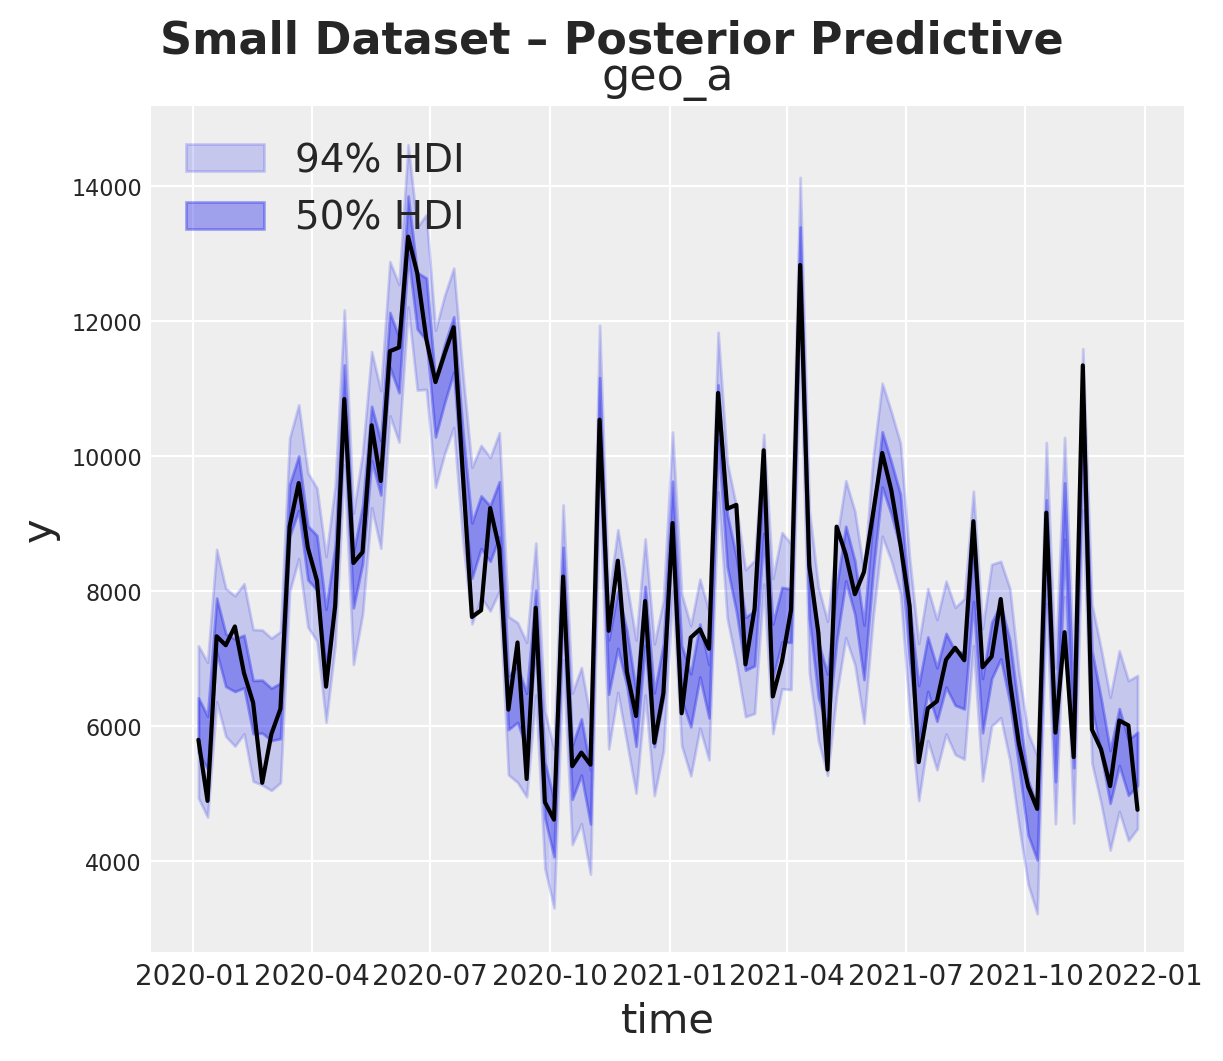


--- Plotting Posterior Predictive for PyMC-Marketing model (growing) ---


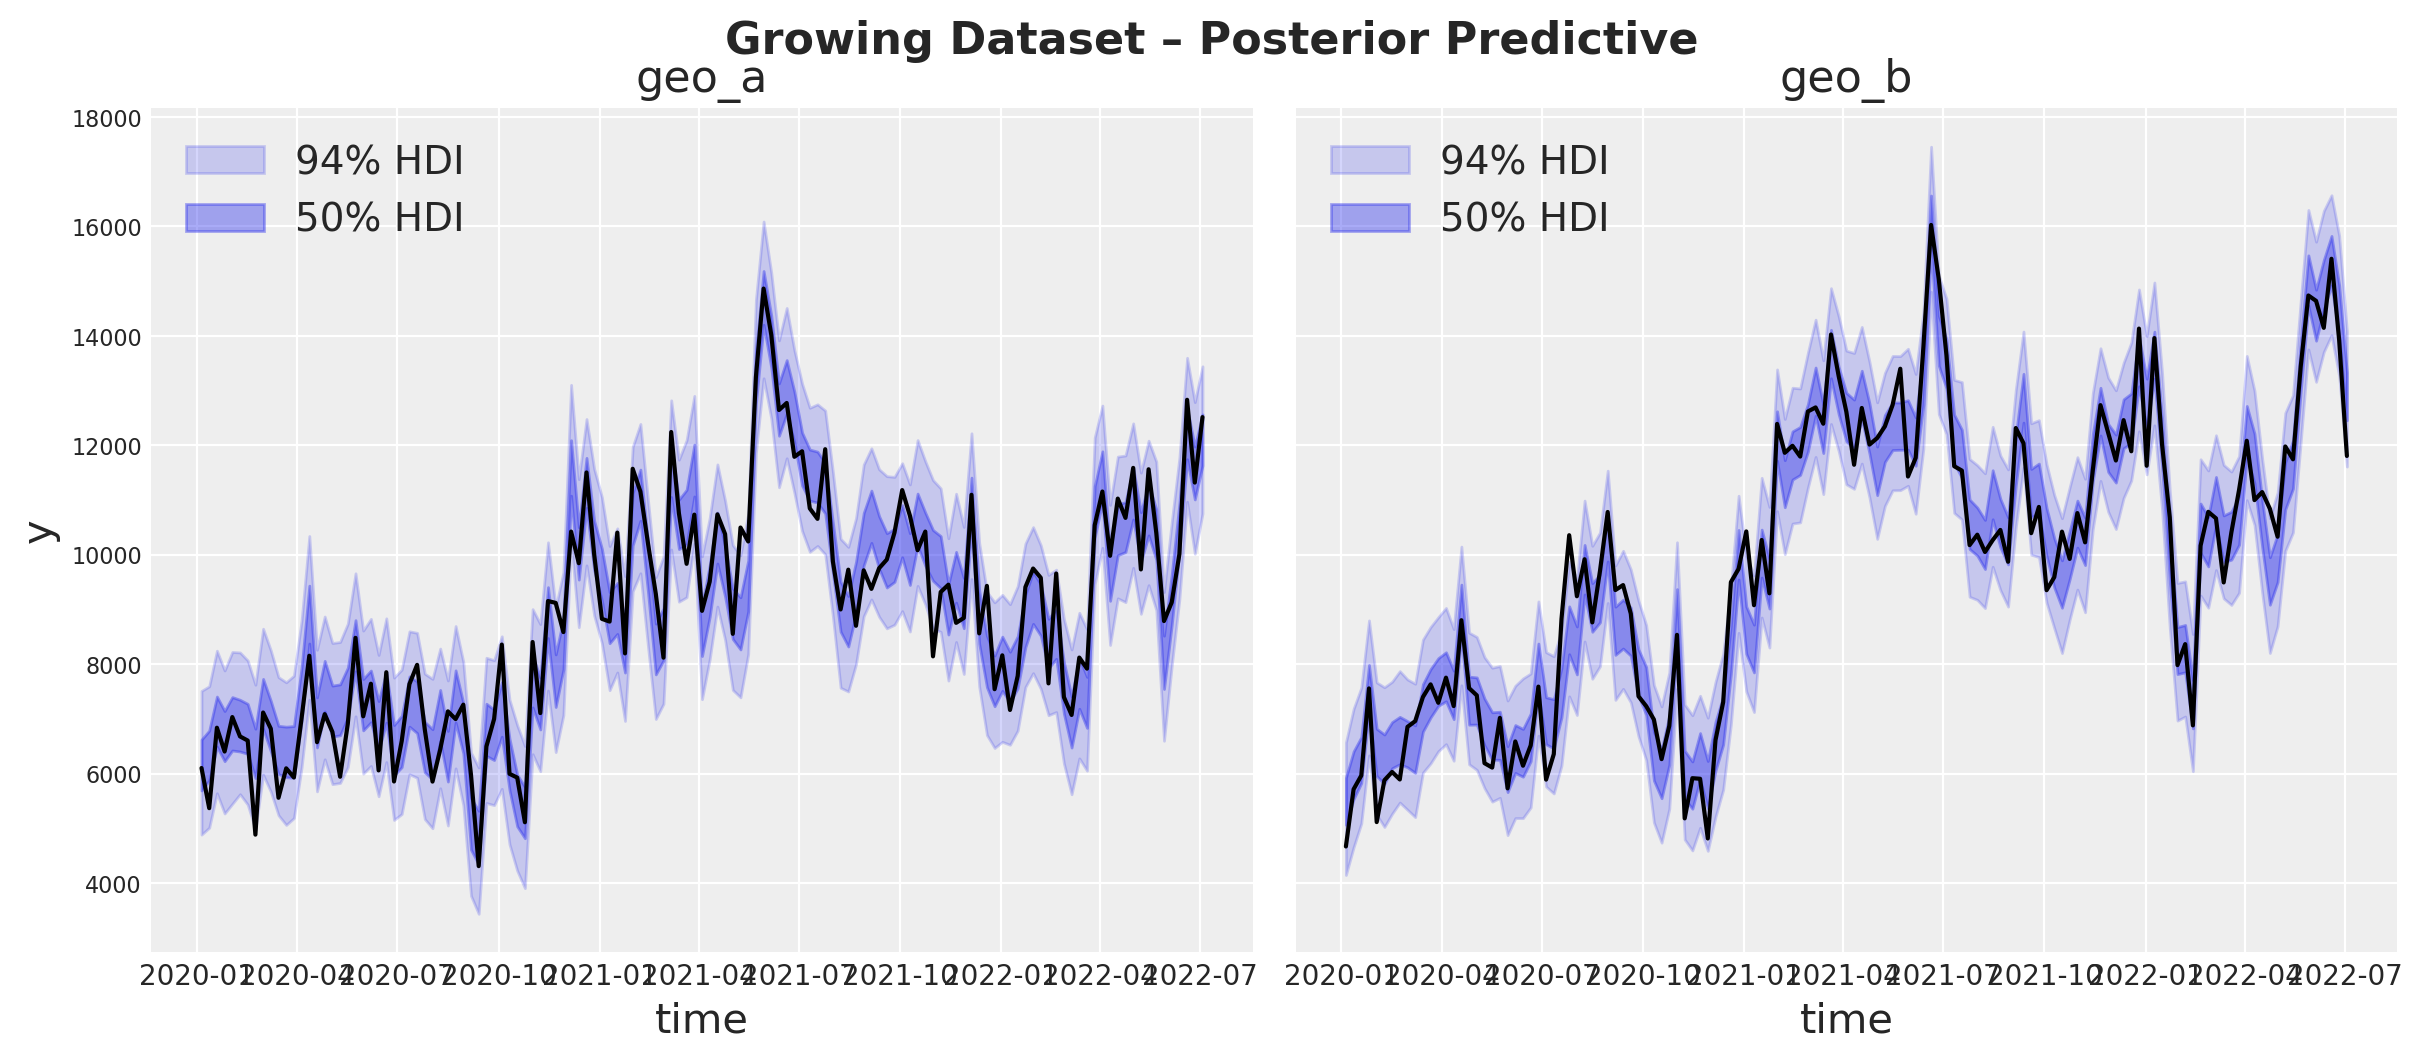

In [18]:
for i, (mmm_model, data_df) in enumerate(zip(pymc_built_models, datasets), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Plotting Posterior Predictive for PyMC-Marketing model ({dataset_name}) ---")

    geos = mmm_model.model.coords["geo"]
    dates = mmm_model.model.coords["date"]

    fig, axes = plt.subplots(
        ncols=len(geos),
        figsize=(6 * len(geos), 5),
        sharex=True,
        sharey=True,
        layout="constrained",
    )

    # Ensure axes is iterable
    if len(geos) == 1:
        axes = [axes]

    for j, geo in enumerate(geos):
        ax = axes[j]
        # 94% HDI
        az.plot_hdi(
            x=dates,
            y=mmm_model.idata["posterior_predictive"].y_original_scale.sel(geo=geo),
            color="C0",
            smooth=False,
            hdi_prob=0.94,
            fill_kwargs={"alpha": 0.2, "label": "94% HDI"},
            ax=ax,
        )

        # 50% HDI
        az.plot_hdi(
            x=dates,
            y=mmm_model.idata["posterior_predictive"].y_original_scale.sel(geo=geo),
            color="C0",
            smooth=False,
            hdi_prob=0.5,
            fill_kwargs={"alpha": 0.4, "label": "50% HDI"},
            ax=ax,
        )

        # Actual data
        sns.lineplot(
            data=data_df.query("geo == @geo"),
            x="time",
            y="y",
            color="black",
            ax=ax,
        )

        ax.legend(loc="upper left")
        ax.set(title=f"{geo}")

    fig.suptitle(f"{dataset_name.title()} Dataset – Posterior Predictive", fontsize=16, fontweight="bold", y=1.03)
    plt.show()


In [33]:
# Collect all rows
all_performance_rows = []

dataset_order = {name: i for i, name in enumerate(dataset_names)}

# --- Meridian ---
for i, meridian_model in enumerate(meridian_models, start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    model_analysis = analyzer.Analyzer(meridian_model)
    fit_data = model_analysis.expected_vs_actual_data()

    for geo in fit_data.geo.values:
        geo_label = "geo_a" if geo == "national_geo" else geo

        expected = fit_data['expected'].sel(geo=geo, metric="mean")
        actual = fit_data['actual'].sel(geo=geo)

        expected_vals = expected.values
        actual_vals = actual.values

        mask = ~np.isnan(expected_vals) & ~np.isnan(actual_vals)
        expected_vals = expected_vals[mask]
        actual_vals = actual_vals[mask]

        if len(expected_vals) < 3:
            continue

        ss_res = np.sum((actual_vals - expected_vals) ** 2)
        ss_tot = np.sum((actual_vals - np.mean(actual_vals)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

        nonzero_mask = actual_vals != 0
        mape = (np.abs((actual_vals[nonzero_mask] - expected_vals[nonzero_mask]) / actual_vals[nonzero_mask])).mean() * 100

        residuals = actual_vals - expected_vals
        dw = durbin_watson(residuals)

        all_performance_rows.append({
            "Library": "Meridian",
            "Geo": geo_label,
            "Dataset": dataset_name,
            "R²": round(r2, 4) if not np.isnan(r2) else None,
            "MAPE (%)": round(mape, 2),
            "Durbin-Watson": round(dw, 3)
        })

# --- PyMC-Marketing ---
for i, (mmm_model, data_df) in enumerate(zip(pymc_built_models, datasets), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]

    for geo in mmm_model.model.coords["geo"]:
        geo_label = "Local" if geo == "national_geo" else geo

        expected = mmm_model.idata["posterior_predictive"].y_original_scale.mean(['chain', 'draw']).sel(geo=geo)
        actual_vals = data_df.loc[data_df["geo"] == geo, "y"]

        expected_vals = expected.values
        actual_vals = actual_vals.values

        mask = ~np.isnan(expected_vals) & ~np.isnan(actual_vals)
        expected_vals = expected_vals[mask]
        actual_vals = actual_vals[mask]

        if len(expected_vals) < 3:
            continue

        ss_res = np.sum((actual_vals - expected_vals) ** 2)
        ss_tot = np.sum((actual_vals - np.mean(actual_vals)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

        nonzero_mask = actual_vals != 0
        mape = (np.abs((actual_vals[nonzero_mask] - expected_vals[nonzero_mask]) / actual_vals[nonzero_mask])).mean() * 100

        residuals = actual_vals - expected_vals
        dw = durbin_watson(residuals)

        all_performance_rows.append({
            "Library": "PyMC-Marketing",
            "Geo": geo_label,
            "Dataset": dataset_name,
            "R²": round(r2, 4) if not np.isnan(r2) else None,
            "MAPE (%)": round(mape, 2),
            "Durbin-Watson": round(dw, 3)
        })

# --- Create and sort final DataFrame ---
performance_df = pd.DataFrame(all_performance_rows)

# Sort by dataset order and geo
performance_df["dataset_order"] = performance_df["Dataset"].map(dataset_order)
performance_df = performance_df.sort_values(by=["dataset_order", "Geo", "Library"]).drop(columns="dataset_order")

# Melt to long format for metrics
melted_df = performance_df.melt(
    id_vars=["Dataset", "Geo", "Library"],
    value_vars=["R²", "MAPE (%)", "Durbin-Watson"],
    var_name="Metric",
    value_name="Value"
)

# Pivot to get columns per library
final_df = melted_df.pivot_table(
    index=["Dataset", "Geo", "Metric"],
    columns="Library",
    values="Value"
).reset_index()

# Remove the column index name (optional)
final_df.columns.name = None

# Reorder and keep only relevant columns
final_df = final_df[["Dataset", "Geo", "Metric", "PyMC-Marketing", "Meridian"]]

# Display final clean table (no 'Library' column)
print("\n=== Final Model Performance Comparison ===")
display(final_df)



=== Final Model Performance Comparison ===


Dataset    Geo         Metric  PyMC-Marketing  Meridian
0  growing  geo_a  Durbin-Watson          1.8700    1.4390
1  growing  geo_a       MAPE (%)          6.0300    5.8900
2  growing  geo_a             R²          0.9105    0.9134
3  growing  geo_b  Durbin-Watson          1.5520    0.9350
4  growing  geo_b       MAPE (%)          5.1000    7.9100
5  growing  geo_b             R²          0.9523    0.8956
6    small  geo_a  Durbin-Watson          1.9860    0.8320
7    small  geo_a       MAPE (%)          5.7100    9.4500
8    small  geo_a             R²          0.9314    0.8001

## Contribution Recovery

In [20]:
predicted_contributions_ds_meridian_list = []
predicted_contributions_ds_pymc_marketing_list = []

for i, (meridian_model, data, mmm_model) in enumerate(zip(
    meridian_models,
    built_data_objects,
    pymc_built_models
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Predicting Contributions for Dataset: {dataset_name} ---")

    # --- Meridian: Predict Contributions ---
    model_analysis = analyzer.Analyzer(meridian_model)

    incremental_df = model_analysis.incremental_outcome(
        aggregate_times=False,
        aggregate_geos=False,
        use_kpi=True,
    )

    mean_np = tf.reduce_mean(incremental_df, axis=[0, 1]).numpy()
    lower_np = tfp.stats.percentile(incremental_df, 3, axis=[0, 1]).numpy()
    upper_np = tfp.stats.percentile(incremental_df, 97, axis=[0, 1]).numpy()

    stacked = tf.stack([mean_np, lower_np, upper_np], axis=0).numpy()

    contrib_da = xr.DataArray(
        stacked,
        dims=["hdi", "geo", "time", "media_channel"],
        coords={
            "hdi": ["mean", "lower", "upper"],
            "geo": data.geo.coords["geo"].values,
            "time": data.time.coords["time"].values,
            "media_channel": data.media.coords["media_channel"].values
        },
        name="contribution"
    )

    predicted_contributions_ds_meridian = contrib_da.to_dataset()
    predicted_contributions_ds_meridian_list.append(predicted_contributions_ds_meridian)

    # --- PyMC-Marketing: Predict Contributions ---
    contribution_da = mmm_model.idata["posterior"]["channel_contribution_original_scale"]
    predicted_contributions_ds_pymc_marketing_list.append(contribution_da)



--- Predicting Contributions for Dataset: small ---

--- Predicting Contributions for Dataset: growing ---


In [21]:
true_contributions_ds_list = []

for i, truth_df in enumerate(truth_dfs):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Processing ground truth for: {dataset_name} ---")

    contrib_df = truth_df.copy()
    channel_cols = [col for col in contrib_df.columns if col.startswith("contribution")]

    long_contrib_df = contrib_df.melt(
        id_vars=["time", "geo"],
        value_vars=channel_cols,
        var_name="media_channel",
        value_name="contribution"
    )

    long_contrib_df["media_channel"] = long_contrib_df["media_channel"]
    long_contrib_df["time"] = pd.to_datetime(long_contrib_df["time"])

    true_contributions_da = (
        long_contrib_df
        .set_index(["time", "geo", "media_channel"])
        .to_xarray()
    )["contribution"]

    true_contributions_ds = true_contributions_da.to_dataset(name="contribution")
    true_contributions_ds_list.append(true_contributions_ds)



--- Processing ground truth for: growing ---

--- Processing ground truth for: small ---


#### Meridian


--- Plotting Contributions Grid with Truth (small) ---


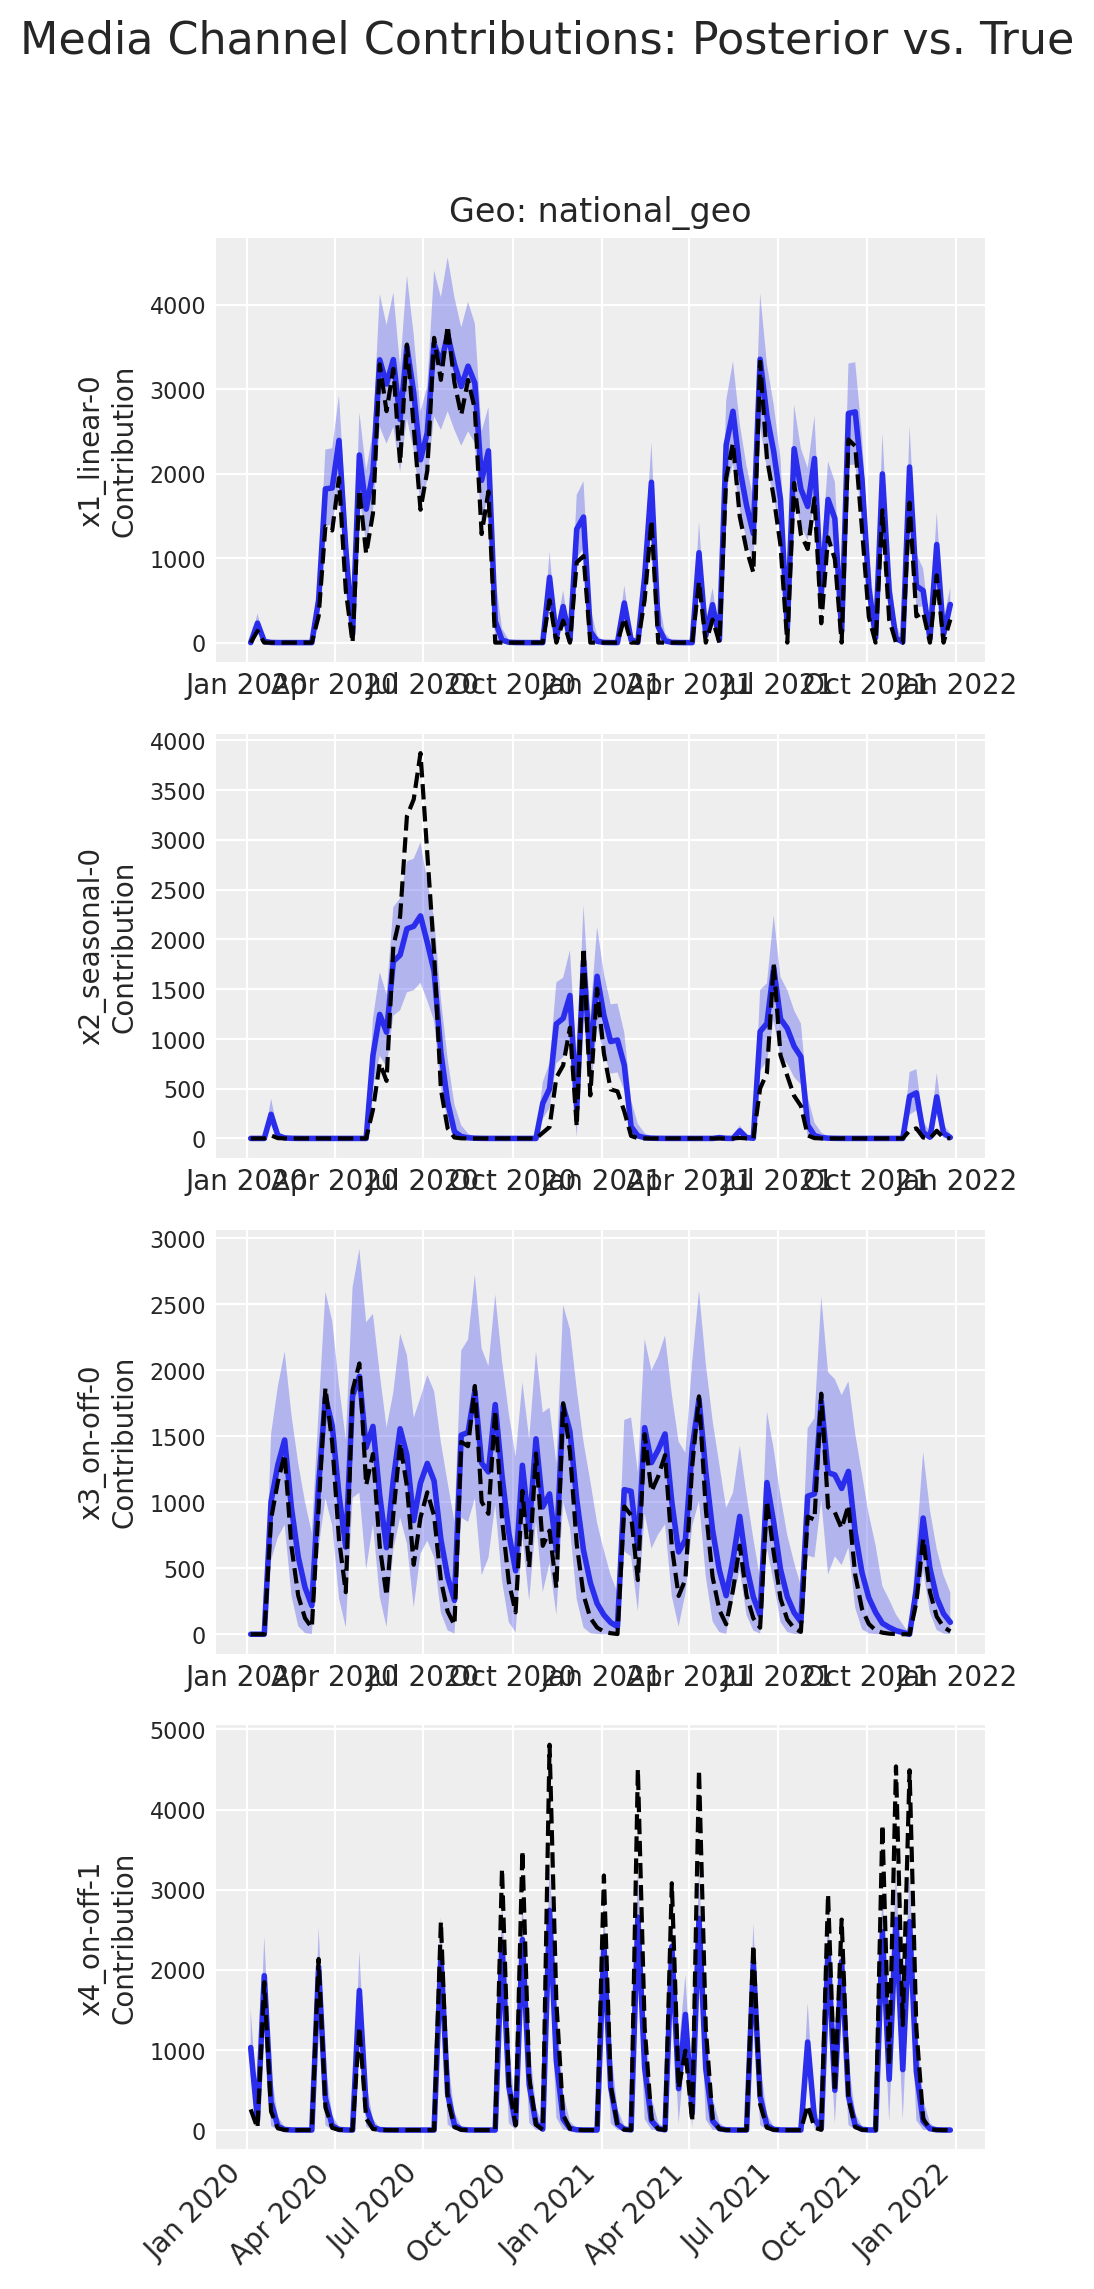


--- Plotting Contributions Grid with Truth (growing) ---


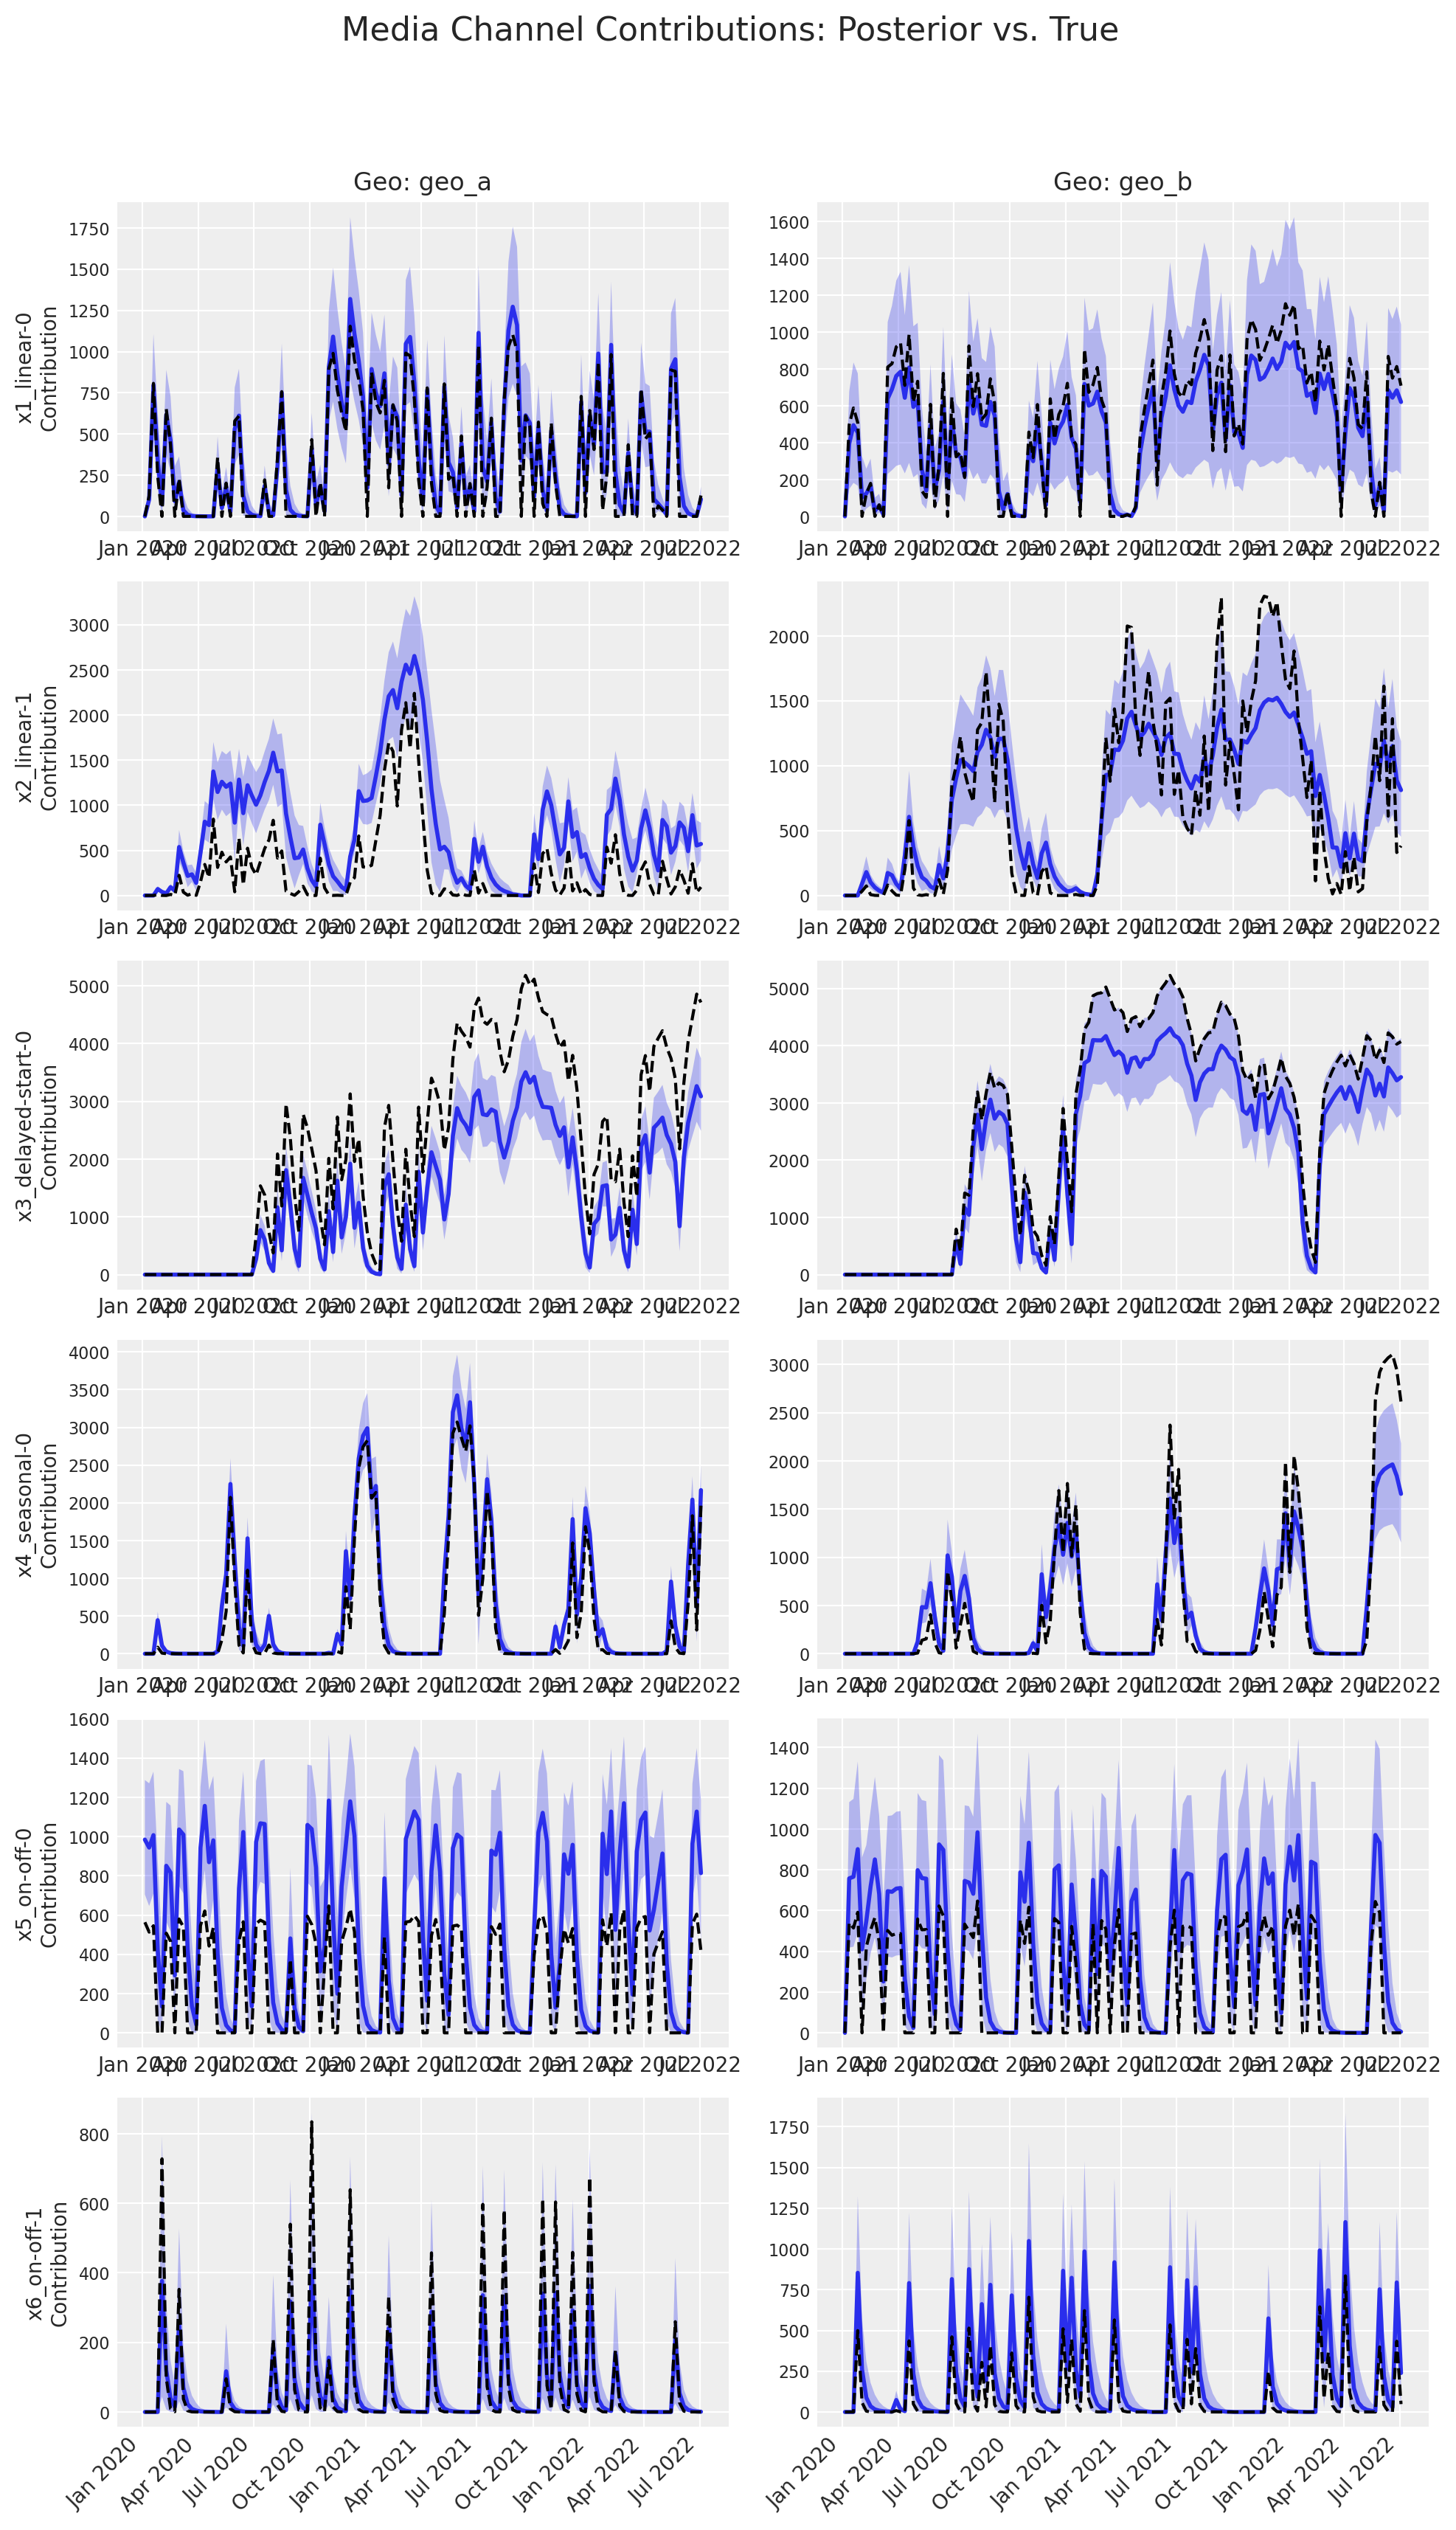

In [22]:
def plot_contributions_grid_with_truth(predicted_contributions_ds, true_contributions_ds):
    """
    Plots a grid of time series with rows = media_channel and cols = geo,
    shading between HDI bounds (lower and upper), and overlays true contributions.

    Parameters:
        predicted_contributions_ds (xarray.Dataset): Posterior Dataset with dims (hdi, geo, time, media_channel)
                                                     and coords hdi=["mean", "lower", "upper"].
        true_contributions_ds (xarray.Dataset): True contributions Dataset with dims
                                                (time, geo, media_channel) and variable "contribution".
    """
    da = predicted_contributions_ds["contribution"]

    geos = da.geo.values
    channels = da.media_channel.values
    time = pd.to_datetime(da.time.values)

    n_rows = len(channels)
    n_cols = len(geos)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=False, sharey=False)
    if n_rows == 1 and n_cols == 1:
        axs = np.array([[axs]])
    elif n_rows == 1:
        axs = np.array([axs])
    elif n_cols == 1:
        axs = np.array([[ax] for ax in axs])


    for i, channel in enumerate(channels):
        for j, geo in enumerate(geos):
            ax = axs[i, j]

            # Posterior mean + HDI
            mean = da.sel(hdi="mean", geo=geo, media_channel=channel)
            lower = da.sel(hdi="lower", geo=geo, media_channel=channel)
            upper = da.sel(hdi="upper", geo=geo, media_channel=channel)

            ax.plot(time, mean, label="Mean", linewidth=2)
            ax.fill_between(time, lower, upper, alpha=0.3, label="HDI (3%–97%)")

            # True contribution
            true_channel = f"contribution_{channel}"
            #try:
            truth = true_contributions_ds['contribution'].sel(media_channel = true_channel, geo= "geo_a" if geo  == "national_geo" else geo)
            truth = truth.sel(time=time)
            ax.plot(time, truth, linestyle="--", color="black", label="True", linewidth=1.5)
            #except KeyError:
            #    pass  # Skip if not found

            if i == 0:
                ax.set_title(f"Geo: {geo}", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"{channel}\nContribution", fontsize=10)

            ax.grid(True)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

    for ax in axs[-1]:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    fig.suptitle("Media Channel Contributions: Posterior vs. True", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
for i, (predicted_contributions_ds, true_contributions_ds) in enumerate(zip(
    predicted_contributions_ds_meridian_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Plotting Contributions Grid with Truth ({dataset_name}) ---")

    true = true_contributions_ds.copy(deep=True)

    # Rename geo in the true dataset for small business (index 0)
    if i == 1 and "Local" in true.geo.values:
        true = true.assign_coords(geo=["geo_a"] if len(true.geo) == 1 else [
            "geo_a" if g == "Local" else g for g in true.geo.values
        ])

    plot_contributions_grid_with_truth(predicted_contributions_ds, true)

#### PyMC-Marketing


--- Plotting Contributions Grid with Truth (small) ---


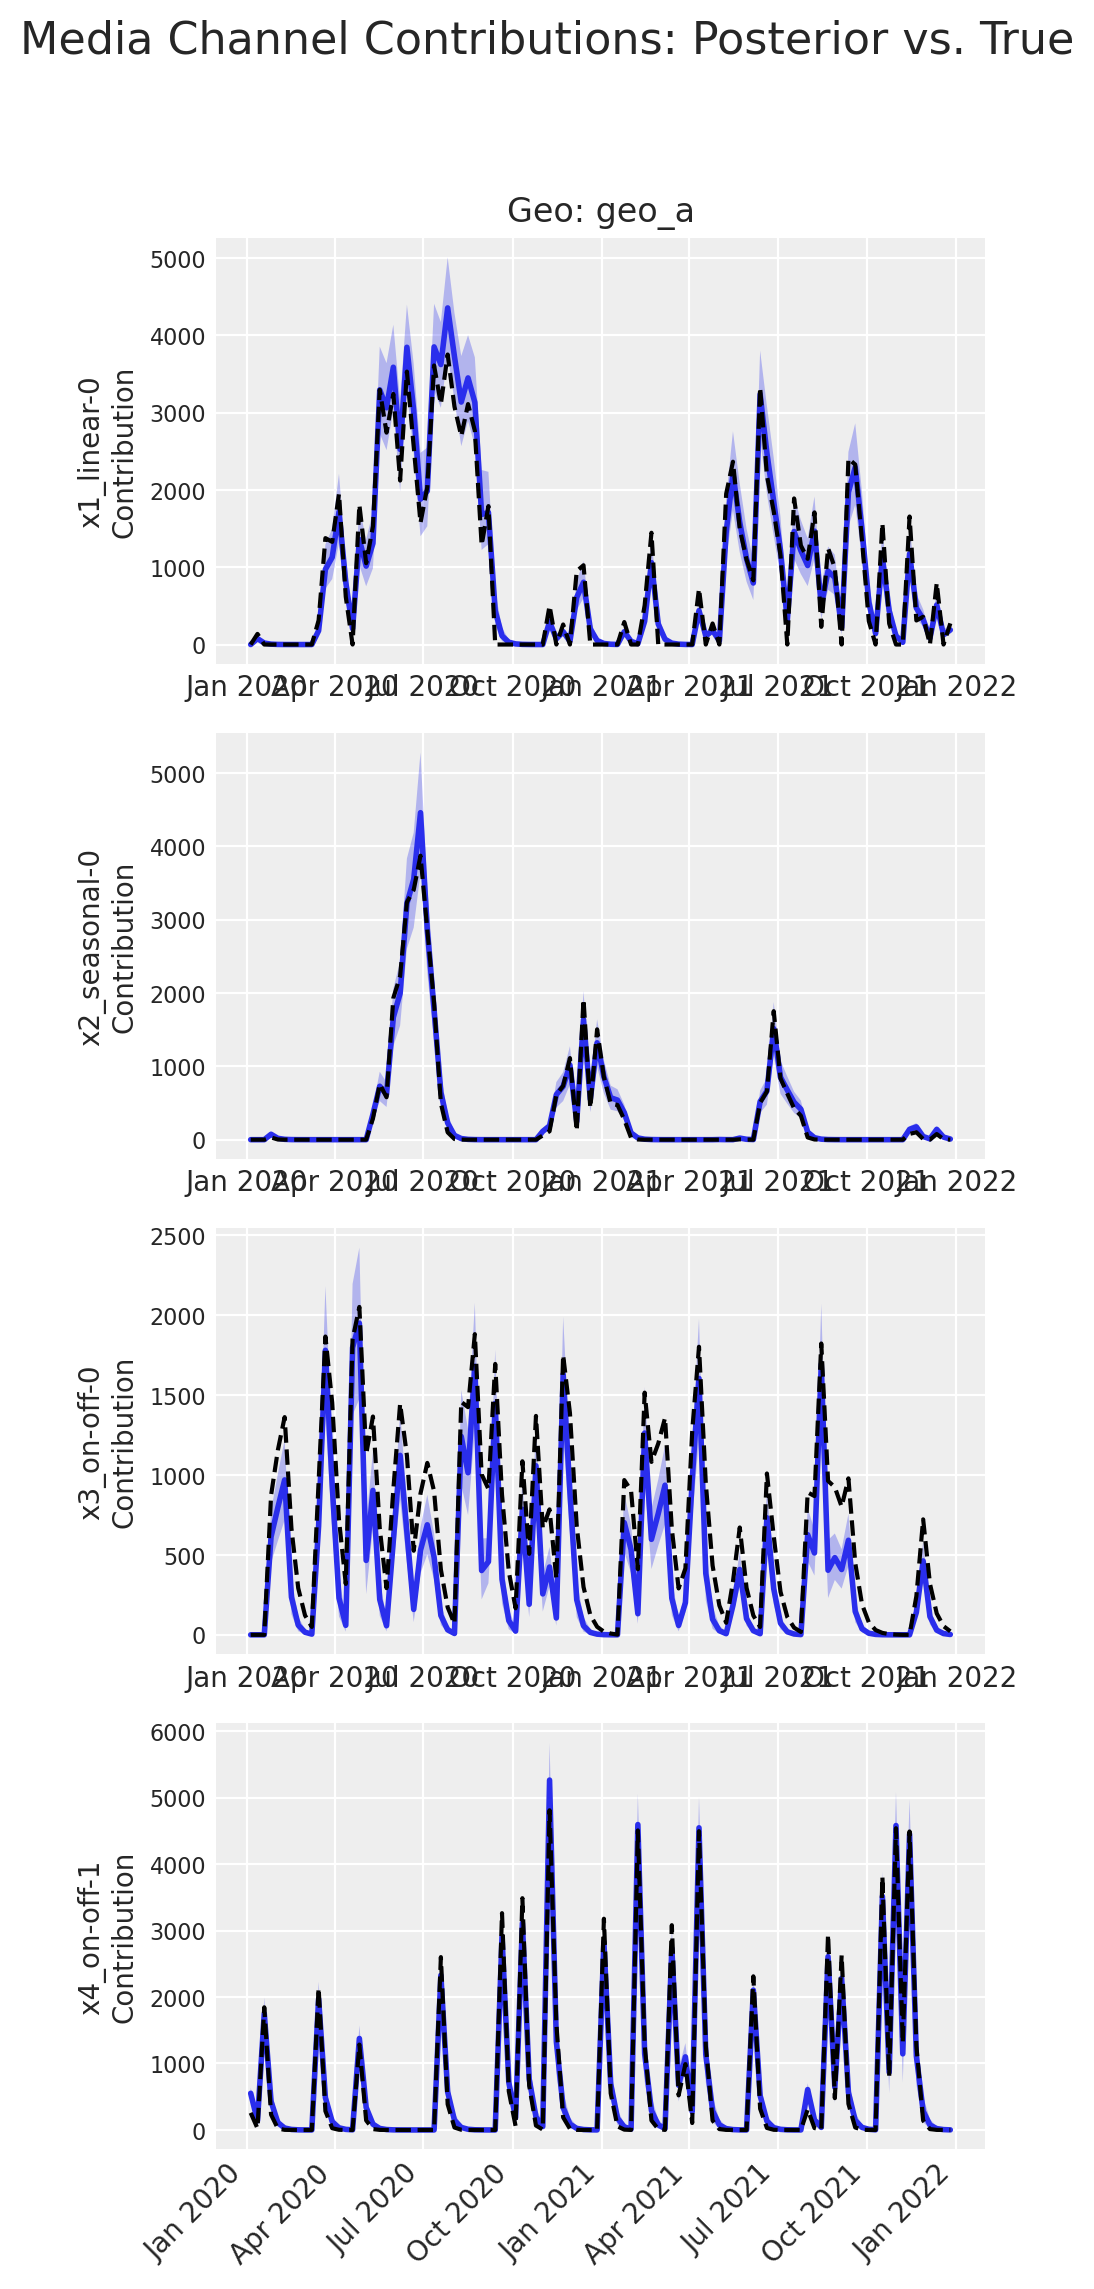


--- Plotting Contributions Grid with Truth (growing) ---


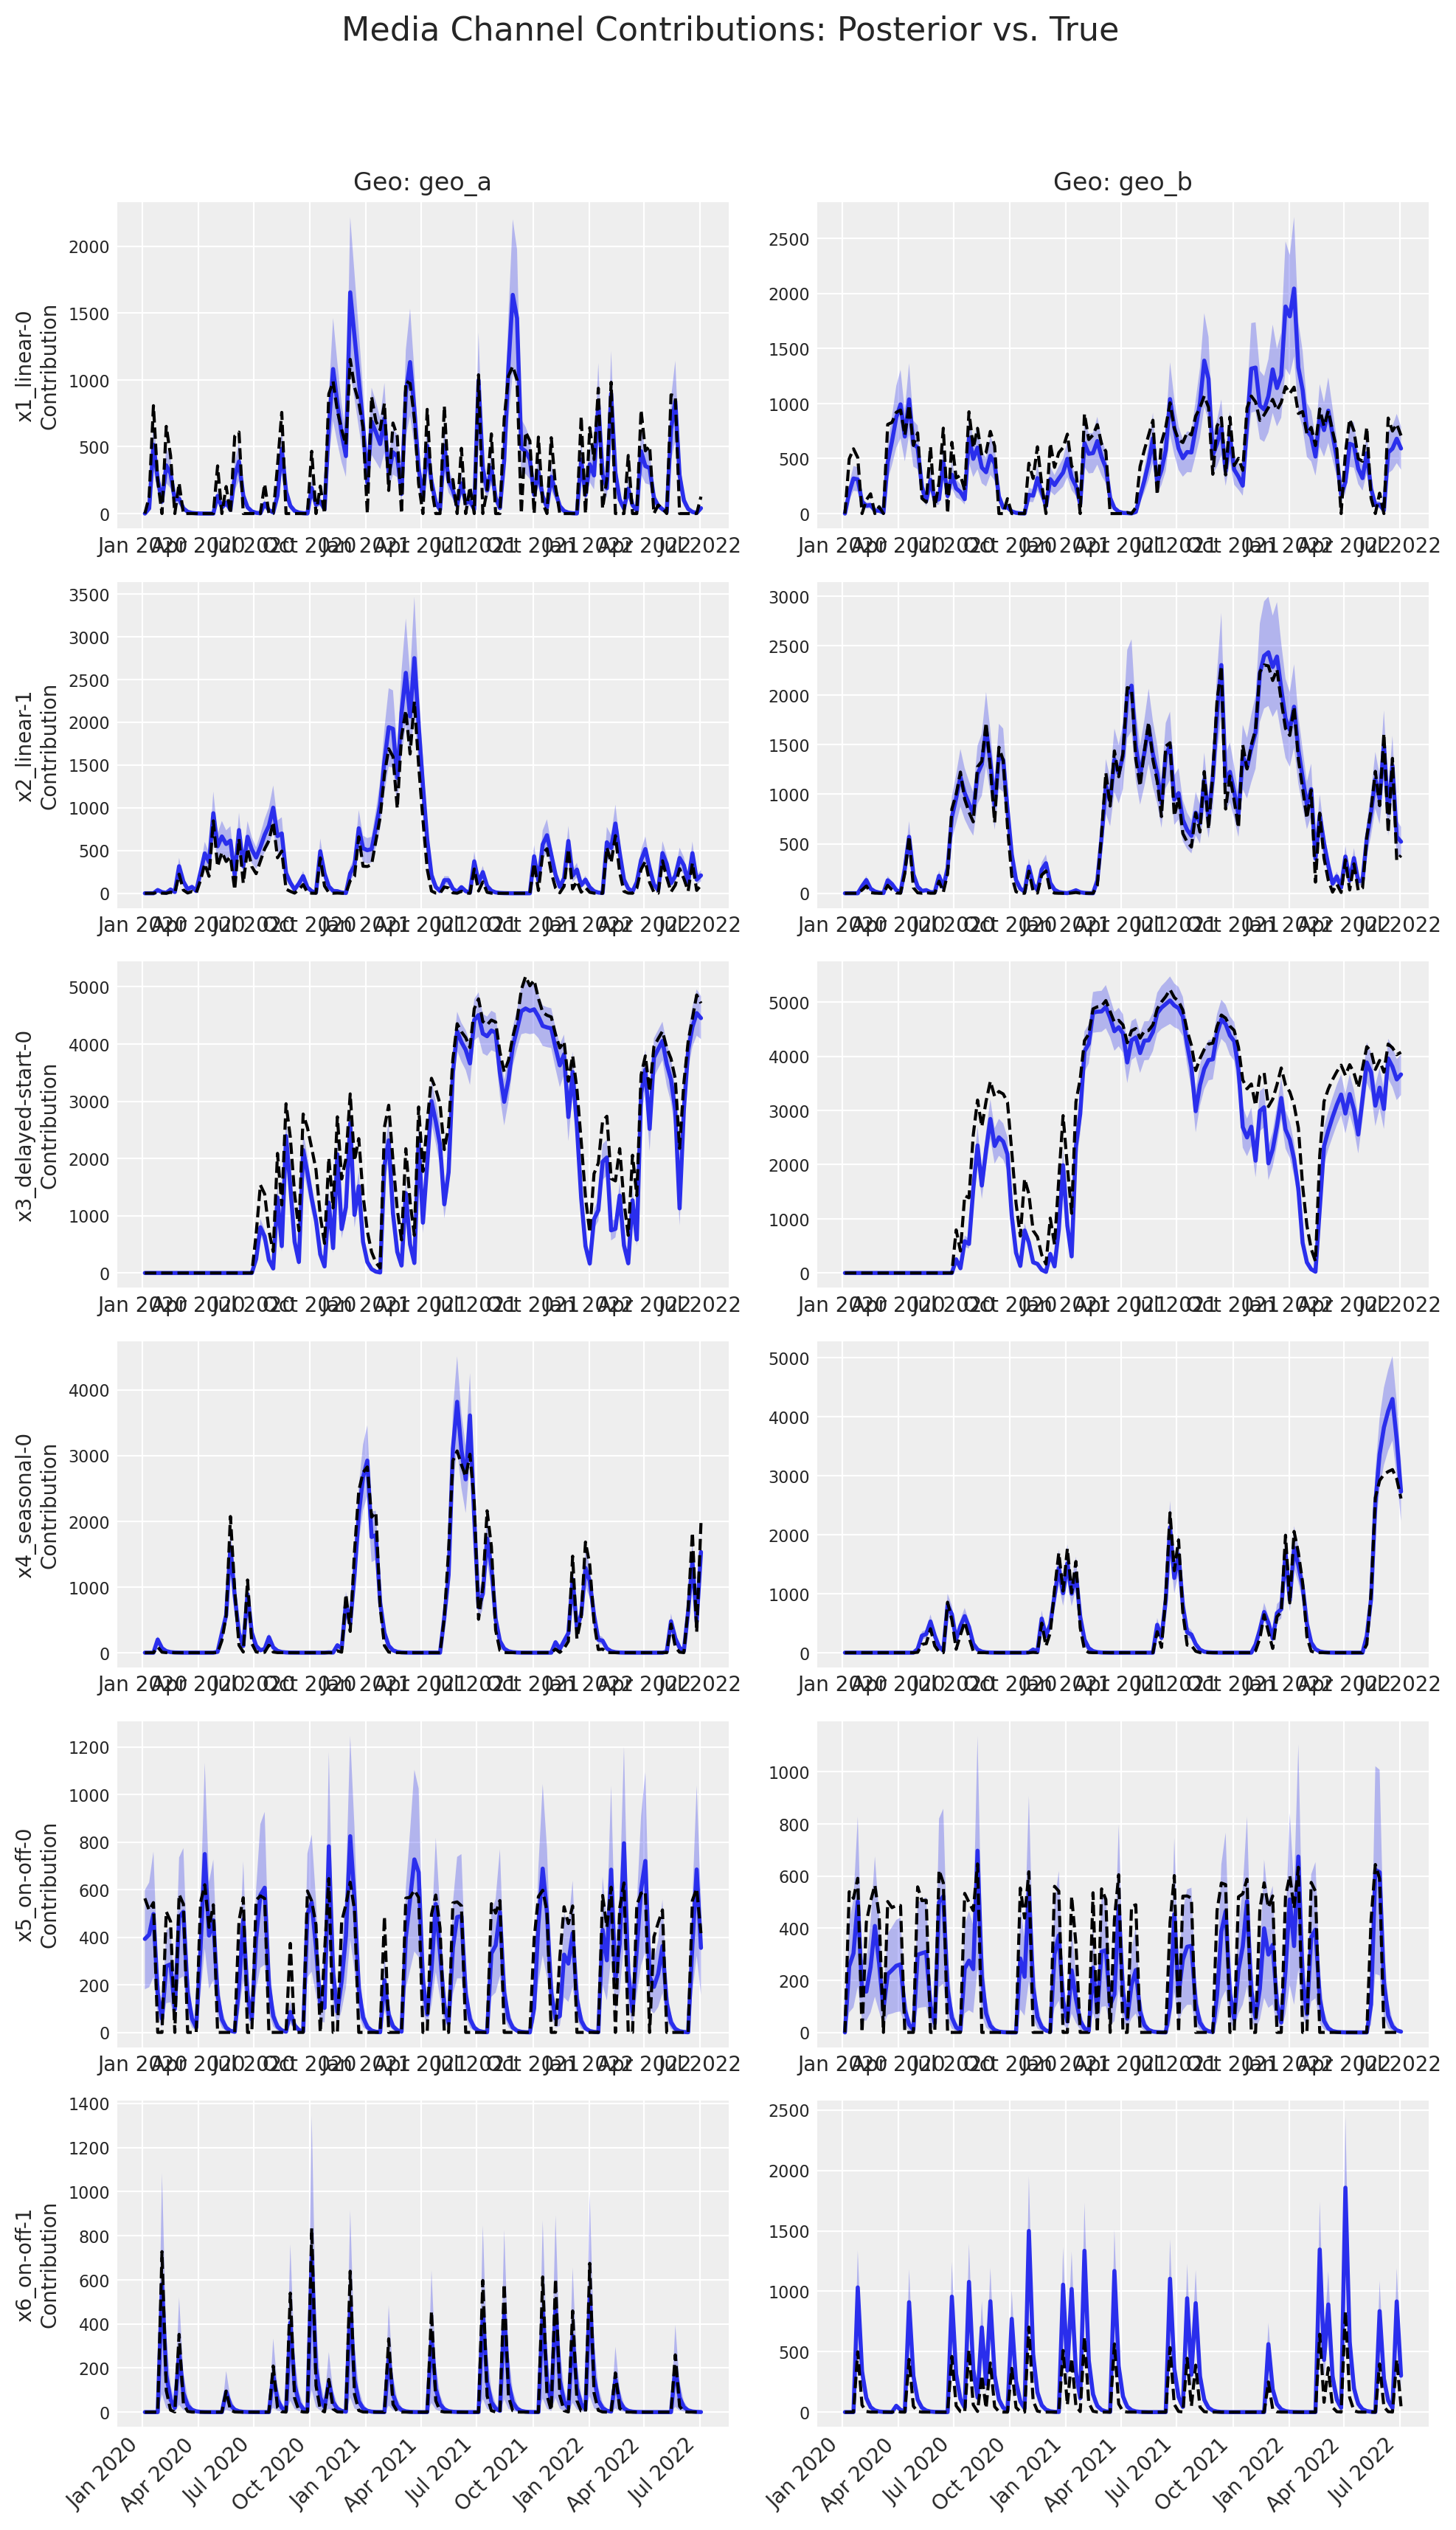

In [23]:
def plot_contributions_grid_with_truth(predicted_contributions_ds, true_contributions_ds):
    """
    Plots a grid of time series with rows = media_channel and cols = geo,
    shading between HDI bounds (3rd–97th percentiles), and overlays true contributions.

    Parameters:
        predicted_contributions_ds (xarray.Dataset): Dataset with dims (chain, draw, date, geo, channel)
        true_contributions_ds (xarray.Dataset): Dataset with vars like 'contribution_x1-seasonal-1'
                                                and dims (date, geo)
    """
    # Extract data
    da = predicted_contributions_ds

    # Collapse (chain, draw) into posterior samples axis
    stacked = da.stack(sample=("chain", "draw"))

    # Compute posterior mean and HDI bounds
    mean = stacked.mean(dim="sample")
    lower = stacked.quantile(0.03, dim="sample")
    upper = stacked.quantile(0.97, dim="sample")

    geos = da.coords["geo"].values
    channels = da.coords["channel"].values
    dates = pd.to_datetime(da.coords["date"].values)

    n_rows = len(channels)
    n_cols = len(geos)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=False, sharey=False)

    # Normalize axs to always be 2D
    if n_rows == 1 and n_cols == 1:
        axs = np.array([[axs]])
    elif n_rows == 1:
        axs = np.array([axs])
    elif n_cols == 1:
        axs = np.array([[ax] for ax in axs])

    for i, channel in enumerate(channels):
        for j, geo in enumerate(geos):
            ax = axs[i, j]

            mean_ts = mean.sel(geo=geo, channel=channel)
            lower_ts = lower.sel(geo=geo, channel=channel)
            upper_ts = upper.sel(geo=geo, channel=channel)

            ax.plot(dates, mean_ts, label="Mean", linewidth=2)
            ax.fill_between(dates, lower_ts, upper_ts, alpha=0.3, label="HDI (3%–97%)")

            # Plot true contributions
            true_var = f"contribution_{channel}"
            try:
                truth = true_contributions_ds['contribution'].sel(media_channel = true_var, geo=geo)
                truth = truth.sel(time=dates)
                ax.plot(dates, truth, linestyle="--", color="black", label="True", linewidth=1.5)
            except KeyError:
                pass  # skip if not found

            if i == 0:
                ax.set_title(f"Geo: {geo}", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"{channel}\nContribution", fontsize=10)

            ax.grid(True)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

    for ax in axs[-1]:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    fig.suptitle("Media Channel Contributions: Posterior vs. True", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_pymc_marketing_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Plotting Contributions Grid with Truth ({dataset_name}) ---")

    # Deep copy both datasets
    pred = predicted_ds.copy(deep=True)
    true = true_ds.copy(deep=True)

    # ✅ Fix geo name in predicted dataset (not true!) for small dataset
    if i == 1 and "Local" in pred.geo.values:
        pred = pred.rename({'geo': 'geo'})  # ensures coordinate is named
        pred = pred.assign_coords(geo=("geo", ["national geo"]))

    plot_contributions_grid_with_truth(predicted_ds, true)


In [24]:
all_detailed_rows = []
summary_rows = []

def compute_smape_rows(predicted_ds, true_ds, lib_type, dataset_name):
    results = []

    def smape(a, f):
        return 100 * np.mean(2 * np.abs(f - a) / (np.abs(f) + np.abs(a) + 1e-8))

    if lib_type == "Meridian":
        pred_da = predicted_ds["contribution"].sel(hdi='mean')
        for geo in true_ds.coords["geo"].values:
            for channel in pred_da.coords["media_channel"].values:
                try:
                    pred = pred_da.sel(geo=geo if "national_geo" not in pred_da.coords["geo"].values else "national_geo", media_channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred.coords["time"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true.coords["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                    df = df[df["true"] != 0]

                    if not df.empty:
                        smape_val = smape(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": geo,
                            "media_channel": channel,
                            "SMAPE (%)": round(smape_val, 2)
                        })

                except KeyError:
                    continue

    elif lib_type == "PyMC Marketing":
        pred_mean = predicted_ds.mean(dim=["chain", "draw"])
        for geo in predicted_ds.geo.values:
            # normalized_geo = "National" if geo in ["national_geo", "Local"] else geo
            for channel in predicted_ds.channel.values:
                try:
                    pred = pred_mean.sel(geo=geo, channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred["date"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                    df = df[df["true"] != 0]

                    if not df.empty:
                        smape_val = smape(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": geo,
                            "media_channel": channel,
                            "SMAPE (%)": round(smape_val, 2)
                        })

                except KeyError:
                    continue

    return results

# Meridian
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_meridian_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    true = true_ds.copy(deep=True)

    rows = compute_smape_rows(predicted_ds, true, lib_type="Meridian", dataset_name=dataset_name)
    all_detailed_rows.extend(rows)
    if rows:
        summary_rows.append({
            "Library": "Meridian",
            "Dataset": dataset_name,
            "Average SMAPE": round(np.mean([r["SMAPE (%)"] for r in rows]), 2)
        })

# PyMC Marketing
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_pymc_marketing_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    rows = compute_smape_rows(predicted_ds, true_ds, lib_type="PyMC Marketing", dataset_name=dataset_name)
    all_detailed_rows.extend(rows)
    if rows:
        summary_rows.append({
            "Library": "PyMC Marketing",
            "Dataset": dataset_name,
            "Average SMAPE": round(np.mean([r["SMAPE (%)"] for r in rows]), 2)
        })

# Convert to DataFrames
detailed_df = pd.DataFrame(all_detailed_rows)
summary_df = pd.DataFrame(summary_rows)

# === Format summary: pivot and clean ===
summary_df = summary_df.pivot(
    index="Dataset",
    columns="Library",
    values="Average SMAPE"
).reset_index()
summary_df.columns.name = None
summary_df = summary_df.round(2)

# === Format detailed: pivot and clean ===
detailed_df = detailed_df.pivot_table(
    index=["Dataset", "geo", "media_channel"],
    columns="Library",
    values="SMAPE (%)"
).reset_index()
detailed_df.columns.name = None
detailed_df = detailed_df.round(2)

# Display
print("\n=== Summary: Average SMAPE per Dataset ===")
display(summary_df)

print("\n=== Detailed SMAPE by Dataset, Geo, and Channel ===")
display(detailed_df)



=== Summary: Average SMAPE per Dataset ===


Dataset  Meridian  PyMC Marketing
0  growing     78.78           74.92
1    small     73.59           81.28


=== Detailed SMAPE by Dataset, Geo, and Channel ===


Dataset    geo       media_channel  Meridian  PyMC Marketing
0   growing  geo_a         x1_linear-0     13.99           41.02
1   growing  geo_a         x2_linear-1    135.27           95.26
2   growing  geo_a  x3_delayed-start-0     68.76           43.83
3   growing  geo_a       x4_seasonal-0    119.97          109.59
4   growing  geo_a         x5_on-off-0     54.88           33.60
5   growing  geo_a         x6_on-off-1    135.05          138.82
6   growing  geo_b         x1_linear-0     16.90           34.68
7   growing  geo_b         x2_linear-1     75.01           55.45
8   growing  geo_b  x3_delayed-start-0     26.62           36.42
9   growing  geo_b       x4_seasonal-0    108.81           97.30
10  growing  geo_b         x5_on-off-0     36.63           52.89
11  growing  geo_b         x6_on-off-1    153.48          160.16
12    small  geo_a         x1_linear-0     30.32           22.95
13    small  geo_a       x2_seasonal-0    126.54          102.86
14    small  geo_a         x3_on-off-0     52.25           88.61
15    small  geo_a         x4_on-off-1     85.23          110.70

In [25]:
all_mape_rows = []
mape_summary_rows = []

def compute_mape_rows(predicted_ds, true_ds, lib_type, dataset_name):
    results = []

    def mape(a, f):
        return 100 * np.mean(np.abs((a - f) / (a + 1e-8)))  # Avoid divide-by-zero

    if lib_type == "Meridian":
        pred_da = predicted_ds["contribution"].sel(hdi='mean')
        for geo in true_ds.coords["geo"].values:
            for channel in pred_da.coords["media_channel"].values:
                try:
                    pred = pred_da.sel(geo=geo if "national_geo" not in pred_da.coords["geo"].values else "national_geo", media_channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred.coords["time"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true.coords["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                    df = df[df["true"] != 0]

                    if not df.empty:
                        mape_val = mape(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": geo,
                            "media_channel": channel,
                            "MAPE (%)": round(mape_val, 2)
                        })

                except KeyError:
                    continue

    elif lib_type == "PyMC Marketing":
        pred_mean = predicted_ds.mean(dim=["chain", "draw"])
        for geo in predicted_ds.geo.values:
            for channel in predicted_ds.channel.values:
                try:
                    pred = pred_mean.sel(geo=geo, channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred["date"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                    df = df[df["true"] != 0]

                    if not df.empty:
                        mape_val = mape(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": geo,
                            "media_channel": channel,
                            "MAPE (%)": round(mape_val, 2)
                        })

                except KeyError:
                    continue

    return results

# Meridian
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_meridian_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1]
    true = true_ds.copy(deep=True)
    if i == 1 and "Local" in true.geo.values:
        true = true.assign_coords(geo=["national_geo"] if len(true.geo) == 1 else [
            "national geo" if g == "Local" else g for g in true.geo.values
        ])

    rows = compute_mape_rows(predicted_ds, true, lib_type="Meridian", dataset_name=dataset_name)
    all_mape_rows.extend(rows)
    if rows:
        mape_summary_rows.append({
            "Library": "Meridian",
            "Dataset": dataset_name,
            "Average MAPE": round(np.mean([r["MAPE (%)"] for r in rows]), 2)
        })

# PyMC Marketing
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_pymc_marketing_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1]
    rows = compute_mape_rows(predicted_ds, true_ds, lib_type="PyMC Marketing", dataset_name=dataset_name)
    all_mape_rows.extend(rows)
    if rows:
        mape_summary_rows.append({
            "Library": "PyMC Marketing",
            "Dataset": dataset_name,
            "Average MAPE": round(np.mean([r["MAPE (%)"] for r in rows]), 2)
        })

# Convert to DataFrames
mape_detailed_df = pd.DataFrame(all_mape_rows)
mape_summary_df = pd.DataFrame(mape_summary_rows)

# === Format summary: pivot and clean ===
mape_summary_df = mape_summary_df.pivot(
    index="Dataset",
    columns="Library",
    values="Average MAPE"
).reset_index()
mape_summary_df.columns.name = None
mape_summary_df = mape_summary_df.round(2)

# === Format detailed: pivot and clean ===
mape_detailed_df = mape_detailed_df.pivot_table(
    index=["Dataset", "geo", "media_channel"],
    columns="Library",
    values="MAPE (%)"
).reset_index()
mape_detailed_df.columns.name = None
mape_detailed_df = mape_detailed_df.round(2)

# Display
print("\n=== Summary: Average MAPE per Dataset ===")
display(mape_summary_df)

print("\n=== Detailed MAPE by Dataset, Geo, and Channel ===")
display(mape_detailed_df)



=== Summary: Average MAPE per Dataset ===


Dataset   Meridian  PyMC Marketing
0  growing_business  598838.16       141400.55
1    small_business   35269.27        10539.36


=== Detailed MAPE by Dataset, Geo, and Channel ===


Dataset    geo       media_channel    Meridian  PyMC Marketing
0   growing_business  geo_a         x1_linear-0       22.10           41.95
1   growing_business  geo_a         x2_linear-1  2212635.24        28125.67
2   growing_business  geo_a  x3_delayed-start-0       49.26           31.62
3   growing_business  geo_a       x4_seasonal-0  1062445.72       476592.57
4   growing_business  geo_a         x5_on-off-0       76.69           26.92
5   growing_business  geo_a         x6_on-off-1   240245.41        81947.33
6   growing_business  geo_b         x1_linear-0       17.30           30.69
7   growing_business  geo_b         x2_linear-1    34780.84         2709.82
8   growing_business  geo_b  x3_delayed-start-0       21.81           26.34
9   growing_business  geo_b       x4_seasonal-0  2879538.12       904397.17
10  growing_business  geo_b         x5_on-off-0       45.15           39.79
11  growing_business  geo_b         x6_on-off-1   756180.32       202836.75
12    small_business  geo_a         x1_linear-0       39.15           22.50
13    small_business  geo_a       x2_seasonal-0   140084.48        31975.03
14    small_business  geo_a         x3_on-off-0      168.33           56.41
15    small_business  geo_a         x4_on-off-1      785.11        10103.48

## Bias Measure

**Total absolute reconstruction error**

In [35]:
all_recon_rows = []
recon_summary_rows = []

def compute_reconstruction_error_rows(predicted_ds, true_ds, lib_type, dataset_name):
    results = []

    def recon_error(a, f):
        return np.mean(a - f)  # mean absolute error

    if lib_type == "Meridian":
        pred_da = predicted_ds["contribution"].sel(hdi='mean')
        for geo in true_ds.coords["geo"].values:
            for channel in pred_da.coords["media_channel"].values:
                try:
                    pred = pred_da.sel(geo=geo if "national_geo" not in pred_da.coords["geo"].values else "national_geo", media_channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred.coords["time"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true.coords["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()

                    if not df.empty:
                        error_val = recon_error(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": geo,
                            "media_channel": channel,
                            "Reconstruction Error": round(error_val, 2)
                        })

                except KeyError:
                    continue

    elif lib_type == "PyMC Marketing":
        pred_mean = predicted_ds.mean(dim=["chain", "draw"])
        for geo in predicted_ds.geo.values:
            for channel in predicted_ds.channel.values:
                try:
                    pred = pred_mean.sel(geo=geo, channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred["date"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()

                    if not df.empty:
                        error_val = recon_error(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": geo,
                            "media_channel": channel,
                            "Reconstruction Error": round(error_val, 2)
                        })

                except KeyError:
                    continue

    return results

# Meridian
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_meridian_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    true = true_ds.copy(deep=True)
    if i == 1 and "Local" in true.geo.values:
        true = true.assign_coords(geo=["national_geo"] if len(true.geo) == 1 else [
            "national geo" if g == "Local" else g for g in true.geo.values
        ])

    rows = compute_reconstruction_error_rows(predicted_ds, true, lib_type="Meridian", dataset_name=dataset_name)
    all_recon_rows.extend(rows)
    if rows:
        recon_summary_rows.append({
            "Library": "Meridian",
            "Dataset": dataset_name,
            "Total Reconstruction Error": round(np.sum([r["Reconstruction Error"] for r in rows]), 2)
        })

# PyMC Marketing
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_pymc_marketing_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    rows = compute_reconstruction_error_rows(predicted_ds, true_ds, lib_type="PyMC Marketing", dataset_name=dataset_name)
    all_recon_rows.extend(rows)
    if rows:
        recon_summary_rows.append({
            "Library": "PyMC Marketing",
            "Dataset": dataset_name,
            "Total Reconstruction Error": round(sum([r["Reconstruction Error"] for r in rows]), 2)
        })

# Convert to DataFrames
recon_detailed_df = pd.DataFrame(all_recon_rows)
recon_summary_df = pd.DataFrame(recon_summary_rows)

# === Format summary: pivot and clean ===
recon_summary_df = recon_summary_df.pivot(
    index="Dataset",
    columns="Library",
    values="Total Reconstruction Error"
).reset_index()
recon_summary_df.columns.name = None
recon_summary_df = recon_summary_df.round(2)

# === Format detailed: pivot and clean ===
recon_detailed_df = recon_detailed_df.pivot_table(
    index=["Dataset", "geo", "media_channel"],
    columns="Library",
    values="Reconstruction Error"
).reset_index()
recon_detailed_df.columns.name = None
recon_detailed_df = recon_detailed_df.round(2)

# Display
print("\n=== Summary: Total Mean Reconstruction Error per Dataset ===")
display(recon_summary_df)

print("\n=== Mean Reconstruction Error by Dataset, Geo, and Channel ===")
display(recon_detailed_df)



=== Summary: Total Mean Reconstruction Error per Dataset ===


Dataset  Meridian  PyMC Marketing
0  growing    287.12          613.94
1    small   -309.62          190.84


=== Mean Reconstruction Error by Dataset, Geo, and Channel ===


Dataset    geo       media_channel  Meridian  PyMC Marketing
0   growing  geo_a         x1_linear-0    -44.72           11.31
1   growing  geo_a         x2_linear-1   -452.46         -116.12
2   growing  geo_a  x3_delayed-start-0    928.57          423.88
3   growing  geo_a       x4_seasonal-0   -120.67           -0.55
4   growing  geo_a         x5_on-off-0   -279.97            7.17
5   growing  geo_a         x6_on-off-1     16.14           -0.27
6   growing  geo_b         x1_linear-0     65.52           44.08
7   growing  geo_b         x2_linear-1    -13.91          -41.86
8   growing  geo_b  x3_delayed-start-0    458.40          432.38
9   growing  geo_b       x4_seasonal-0     18.08          -50.26
10  growing  geo_b         x5_on-off-0   -180.87           58.42
11  growing  geo_b         x6_on-off-1   -106.99         -154.24
12    small  geo_a         x1_linear-0   -226.88          -25.22
13    small  geo_a       x2_seasonal-0    -53.78          -11.52
14    small  geo_a         x3_on-off-0   -183.84          246.64
15    small  geo_a         x4_on-off-1    154.88          -19.06

## Accuracy measure

**Average Scaled RMSE**

In [27]:
all_rmse_rows = []
rmse_summary_rows = []

def compute_rmse_rows(predicted_ds, true_ds, lib_type, dataset_name):
    results = []

    def scaled_rmse(a, f):
        mse = np.mean((a - f) ** 2)
        rmse = np.sqrt(mse)
        scale = np.mean(np.abs(a)) + 1e-8  # avoid divide-by-zero
        return rmse / scale

    if lib_type == "Meridian":
        pred_da = predicted_ds["contribution"].sel(hdi='mean')
        for geo in true_ds.coords["geo"].values:
            for channel in pred_da.coords["media_channel"].values:
                try:
                    pred = pred_da.sel(geo=geo if "national_geo" not in pred_da.coords["geo"].values else "national_geo", media_channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred.coords["time"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true.coords["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()

                    if not df.empty:
                        rmse_val = scaled_rmse(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": geo,
                            "media_channel": channel,
                            "Scaled RMSE": round(rmse_val, 4)
                        })

                except KeyError:
                    continue

    elif lib_type == "PyMC Marketing":
        pred_mean = predicted_ds.mean(dim=["chain", "draw"])
        for geo in predicted_ds.geo.values:
            for channel in predicted_ds.channel.values:
                try:
                    pred = pred_mean.sel(geo=geo, channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred["date"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()

                    if not df.empty:
                        rmse_val = scaled_rmse(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": geo,
                            "media_channel": channel,
                            "Scaled RMSE": round(rmse_val, 4)
                        })

                except KeyError:
                    continue

    return results

# Meridian
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_meridian_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    true = true_ds.copy(deep=True)
    if i == 1 and "Local" in true.geo.values:
        true = true.assign_coords(geo=["national_geo"] if len(true.geo) == 1 else [
            "national geo" if g == "Local" else g for g in true.geo.values
        ])

    rows = compute_rmse_rows(predicted_ds, true, lib_type="Meridian", dataset_name=dataset_name)
    all_rmse_rows.extend(rows)
    if rows:
        rmse_summary_rows.append({
            "Library": "Meridian",
            "Dataset": dataset_name,
            "Average Scaled RMSE": round(np.mean([r["Scaled RMSE"] for r in rows]), 4)
        })

# PyMC Marketing
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_pymc_marketing_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    rows = compute_rmse_rows(predicted_ds, true_ds, lib_type="PyMC Marketing", dataset_name=dataset_name)
    all_rmse_rows.extend(rows)
    if rows:
        rmse_summary_rows.append({
            "Library": "PyMC Marketing",
            "Dataset": dataset_name,
            "Average Scaled RMSE": round(np.mean([r["Scaled RMSE"] for r in rows]), 4)
        })

# Convert to DataFrames
rmse_detailed_df = pd.DataFrame(all_rmse_rows)
rmse_summary_df = pd.DataFrame(rmse_summary_rows)

# === Format summary: pivot and clean ===
rmse_summary_df = rmse_summary_df.pivot(
    index="Dataset",
    columns="Library",
    values="Average Scaled RMSE"
).reset_index()
rmse_summary_df.columns.name = None
rmse_summary_df = rmse_summary_df.round(4)

# === Format detailed: pivot and clean ===
rmse_detailed_df = rmse_detailed_df.pivot_table(
    index=["Dataset", "geo", "media_channel"],
    columns="Library",
    values="Scaled RMSE"
).reset_index()
rmse_detailed_df.columns.name = None
rmse_detailed_df = rmse_detailed_df.round(4)

# Display
print("\n=== Summary: Average Scaled RMSE per Dataset ===")
display(rmse_summary_df)

print("\n=== Scaled RMSE by Dataset, Geo, and Channel ===")
display(rmse_detailed_df)



=== Summary: Average Scaled RMSE per Dataset ===


Dataset  Meridian  PyMC Marketing
0  growing    0.8461          0.6466
1    small    0.5933          0.2910


=== Scaled RMSE by Dataset, Geo, and Channel ===


Dataset    geo       media_channel  Meridian  PyMC Marketing
0   growing  geo_a         x1_linear-0    0.2737          0.5573
1   growing  geo_a         x2_linear-1    1.9373          0.5558
2   growing  geo_a  x3_delayed-start-0    0.4934          0.2385
3   growing  geo_a       x4_seasonal-0    0.4485          0.3711
4   growing  geo_a         x5_on-off-0    1.3705          0.5146
5   growing  geo_a         x6_on-off-1    1.1604          0.6708
6   growing  geo_b         x1_linear-0    0.2019          0.3734
7   growing  geo_b         x2_linear-1    0.4189          0.1226
8   growing  geo_b  x3_delayed-start-0    0.2000          0.2101
9   growing  geo_b       x4_seasonal-0    0.7551          0.4826
10  growing  geo_b         x5_on-off-0    0.9626          0.6662
11  growing  geo_b         x6_on-off-1    1.9310          2.9961
12    small  geo_a         x1_linear-0    0.3244          0.2500
13    small  geo_a       x2_seasonal-0    0.9583          0.2586
14    small  geo_a         x3_on-off-0    0.3224          0.4425
15    small  geo_a         x4_on-off-1    0.7680          0.2130